In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests, linear_regression
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

In [4]:
# replication of Losconczy preprint

# https://www.biorxiv.org/content/10.1101/2021.07.02.450956v1.full.pdf

# and sheffield 

# https://www-nature-com.stanford.idm.oclc.org/articles/s41467-021-23260-3#Sec8

### field stats analysis

In [84]:


def get_field_stats(field_mask):
#     sigfield_cells = field_mask.sum(axis=0)>0
    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask
#     _field_mask = 1.*field_mask
#     _field_mask = _field_mask[:,sigfield_cells]
    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
#     mask = field_widths>2
#     rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, chan='channel_1', n_perms = 1000, pcnt = 99, _ts_key = 'spks_smooth'):
    
    
    
    def _run_fields(nov):
        if nov:
            trial_mask = sess.trial_info['LR']==sess.novel_arm
        else:
            trial_mask = sess.trial_info['LR']== -1*sess.novel_arm

        ts_key = chan + '_' + _ts_key
        shuff_mat = np.zeros([1000, *sess.trial_matrices[ts_key].shape[1:]])
        trial_mat = sess.trial_matrices[ts_key][trial_mask,:,:]
        n_trials = trial_mat.shape[0]
        
        shuffs = rng.integers(trial_mat.shape[1], size = [n_perms, trial_mat.shape[0]])
        
        # calculate shuffles
        _tmat = 0*trial_mat
        for perm in range(n_perms):
            for trial in range(n_trials):
                _tmat[trial,:,:] = np.roll(trial_mat[trial,:,:], shuffs[perm, trial])
            shuff_mat[perm,:,:] = np.nanmean(_tmat, axis=0)
            
        thresh = np.nanpercentile(shuff_mat,pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'channel': chan,
            'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    return {'fam': _run_fields(False), 'nov': _run_fields(True)}




In [85]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6))
# ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in sparse_mice}
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in sparse_mice}

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

In [86]:
np.save('place_field_stats_spks_smooth.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

In [144]:
field_info = np.load("C:/Users/esay/data/Stx3/sparse_analyses/field_prop/field_info_dff.pkl", allow_pickle=True)

In [2]:
_res = np.load("C:/Users/esay/data/Stx3/sparse_analyses/sig_fields/place_field_stats_dff.npy", allow_pickle=True).all()
# _res = np.load("./place_field_stats_spks_smooth.npy", allow_pickle=True).all()

ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

[0.         0.19789315 0.16629044 0.16629044 0.11813394 0.08878856
 0.06094808 0.05869074 0.04514673 0.03085026 0.01429646 0.01805869
 0.00978179 0.00902935 0.00150489 0.00376223 0.00225734 0.00075245
 0.00752445]
15.0


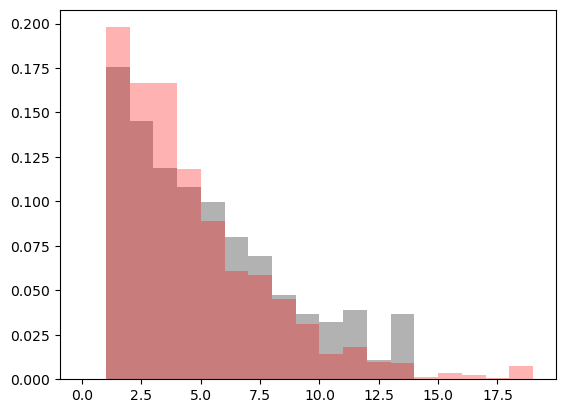

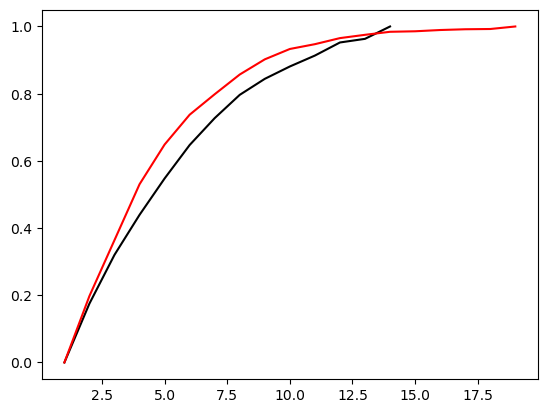

In [4]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in sparse_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['field_widths'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw, bins = np.arange(15), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color= 'black')

ko_fw = []
for mouse in sparse_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['field_widths'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw, bins = np.arange(20), color = 'red', alpha = .3,density=True)
print(hist)

print(np.percentile(ctrl_fw, 95))


ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

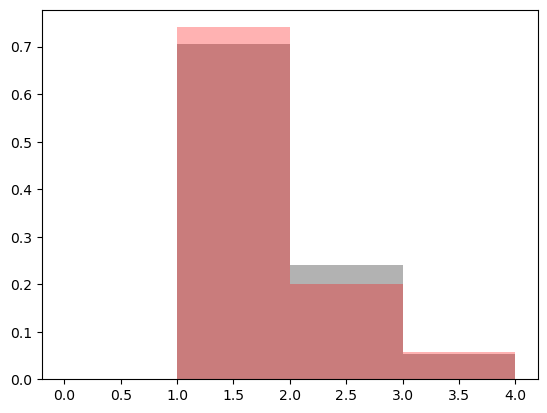

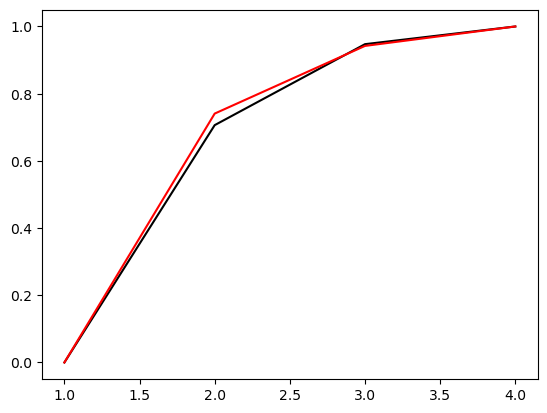

In [5]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in sparse_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['num_fields'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw[ctrl_fw>0], bins = np.arange(5), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='black')

ko_fw = []
for mouse in sparse_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['num_fields'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw[ko_fw>0], bins = np.arange(5), color = 'red', alpha = .3,density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

In [23]:
sess = u.load_single_day('SparseKO_06', 0)
sess.trial_matrices.keys()

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'channel_0_licks', 'channel_0_speed', 'channel_1_licks', 'channel_1_speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt', 'channel_0_spks_speed_filt', 'channel_1_spks_speed_filt', 'channel_0_spks_smooth', 'channel_1_spks_smooth', 'licks'])

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:114: RuntimeWarning: Mean of empty slice
  'speed': np.nanmean(np.nanmean(sess.trial_matrices['channel_0_speed'][trial_mask,:],axis=0)),
C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 0,


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_118740\3251402049.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ko': 1,


NameError: name 'figdir' is not defined

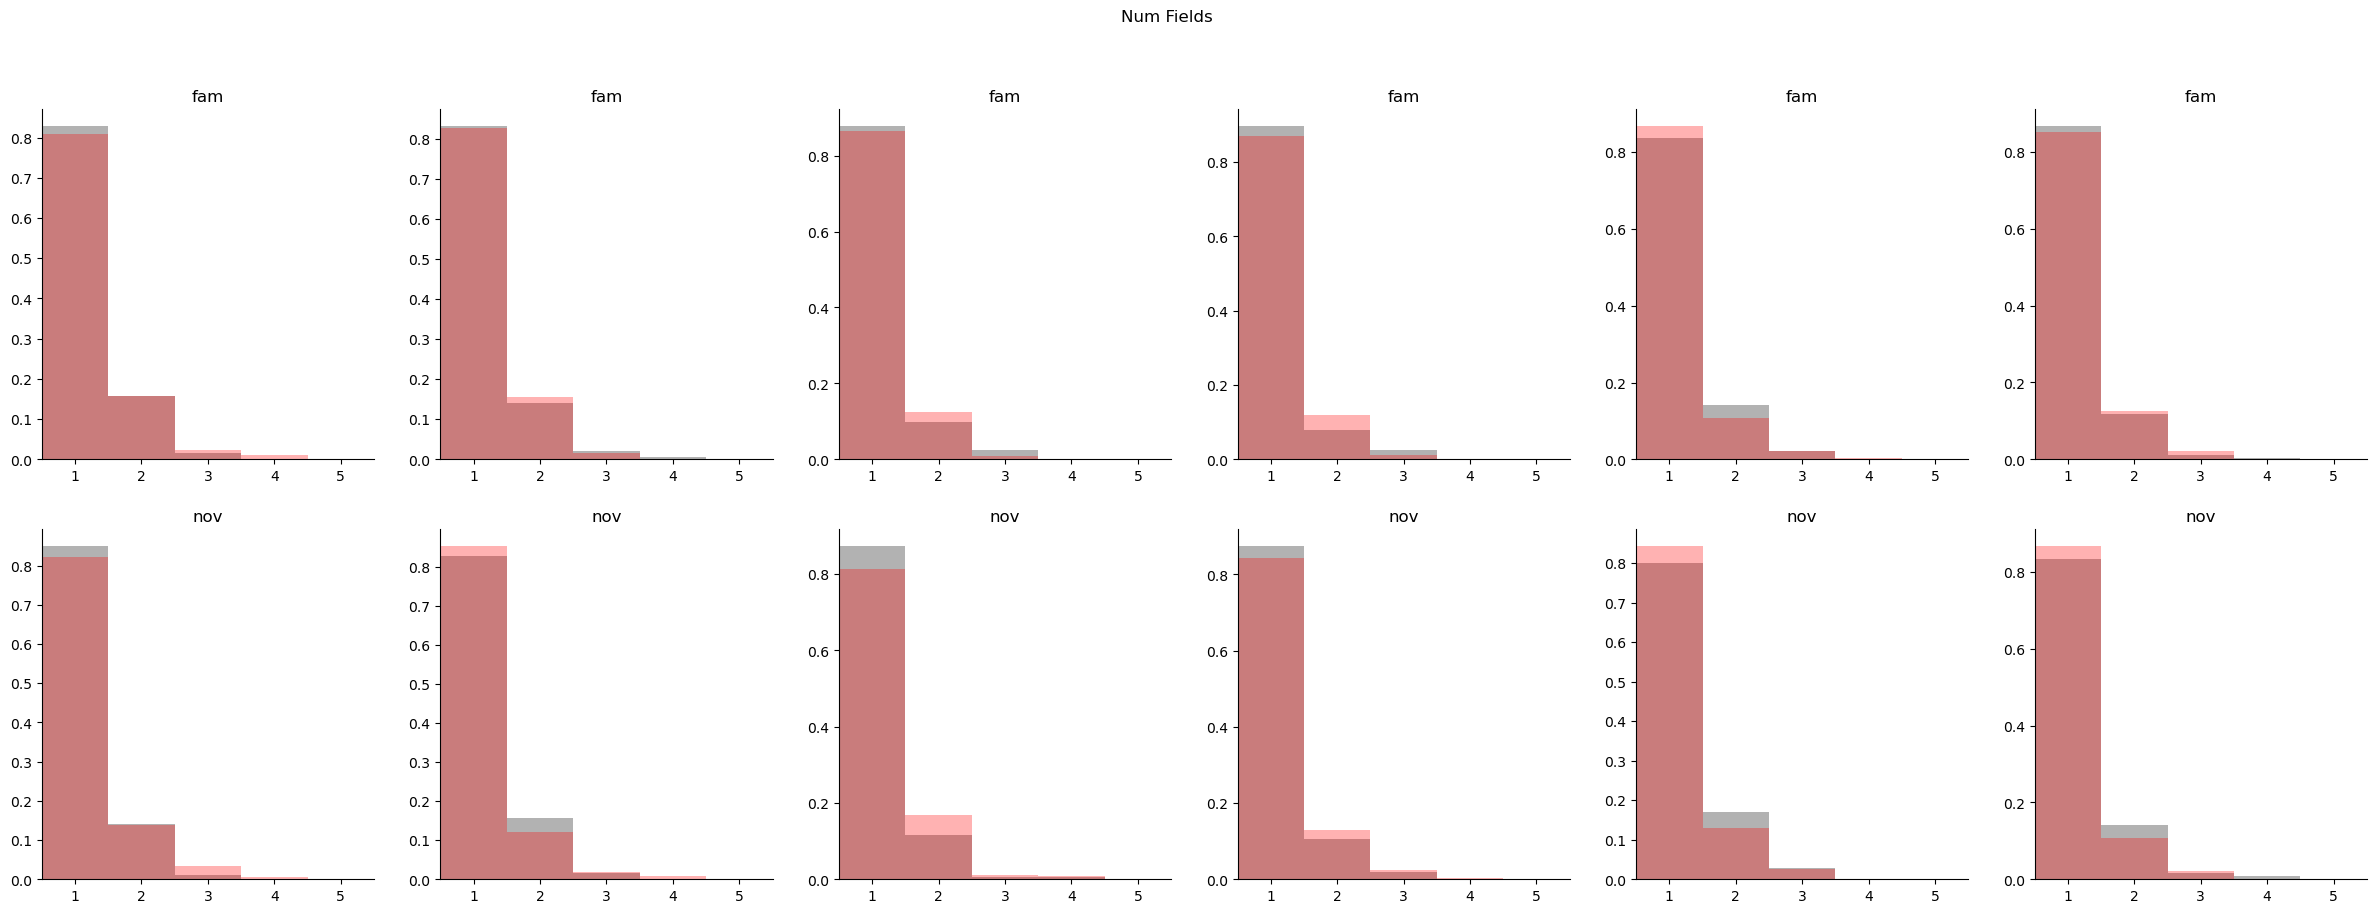

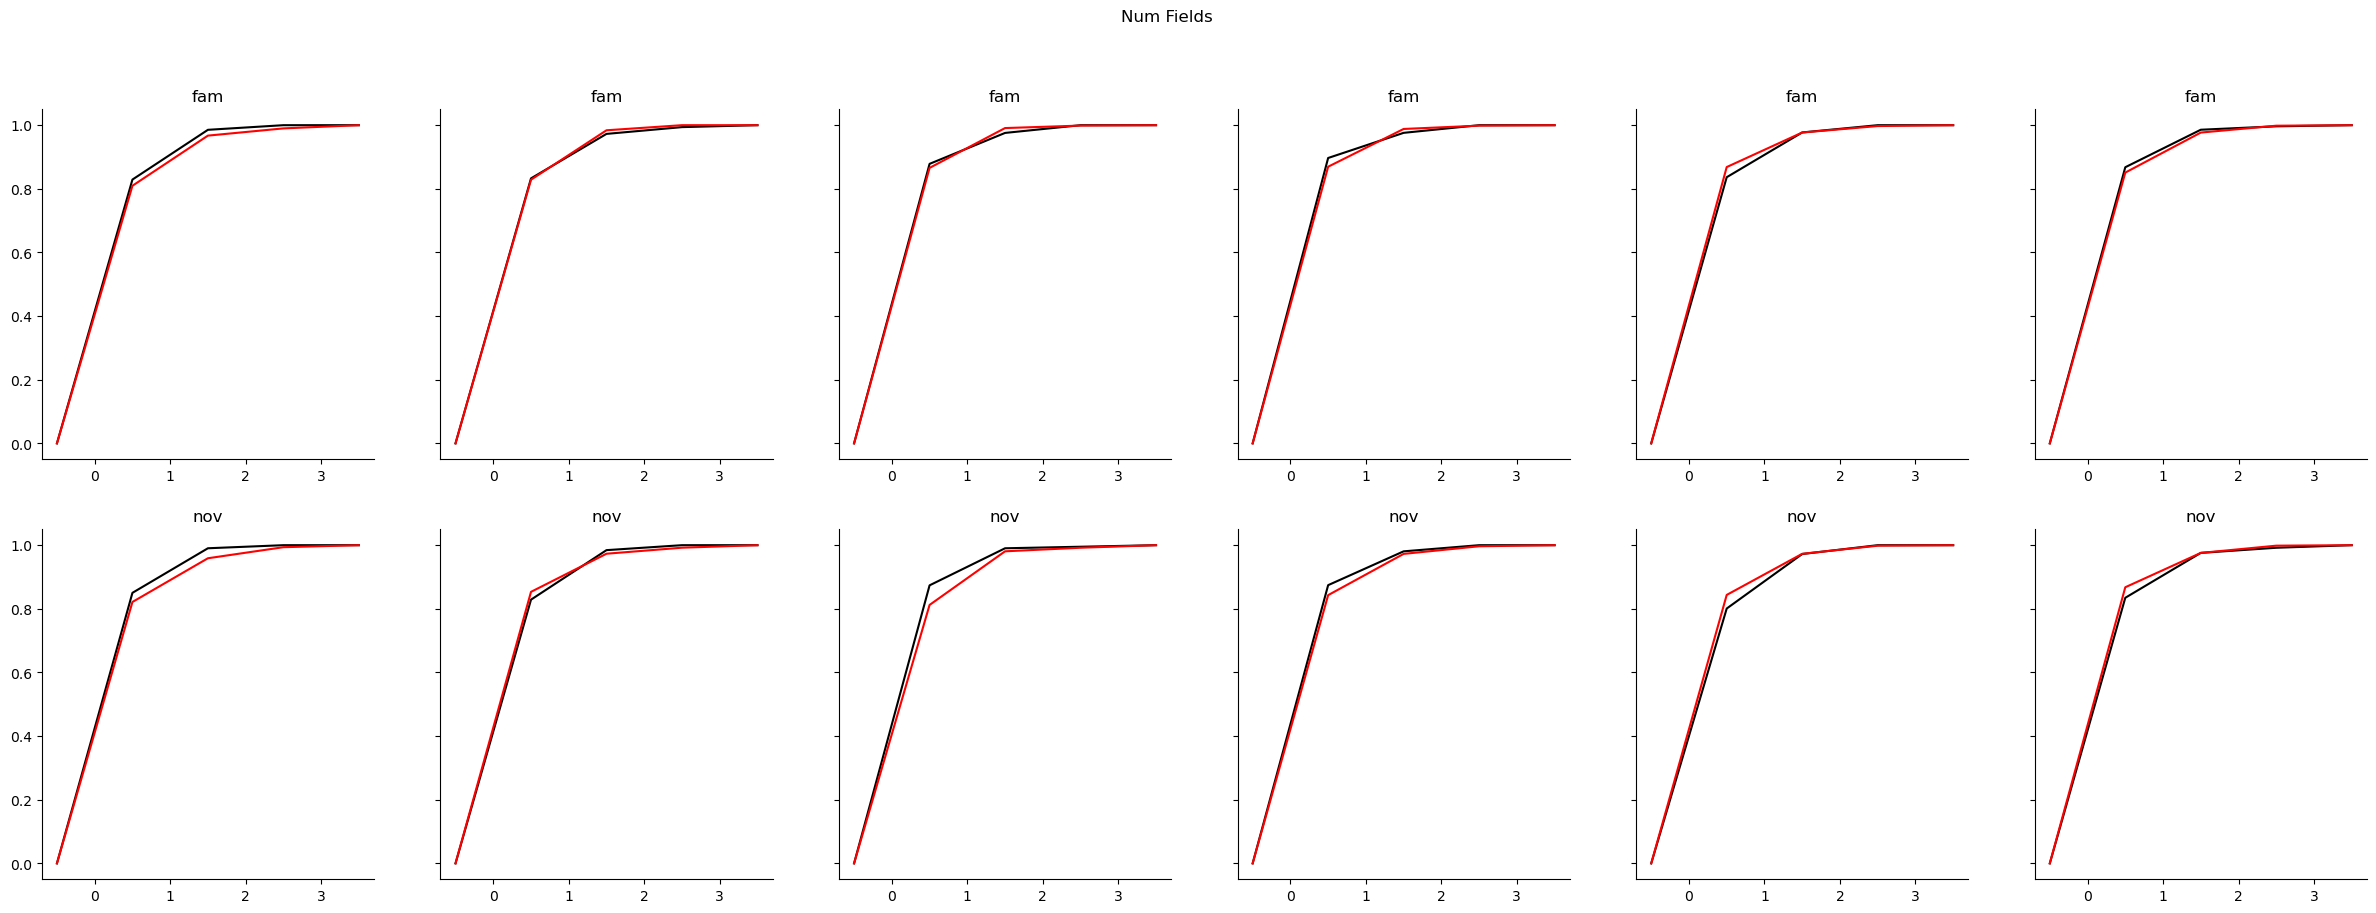

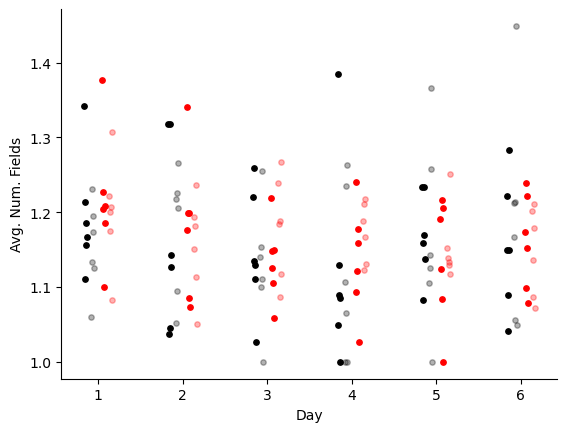

In [83]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize=[30,10],sharey=True)

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'day_norm': [],
                   'nov': [],
                   'num_fields' : [],
                   'mouse': [], 
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})

days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in sparse_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ctrl_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ctrl_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
# #             dat = f[:,1]-r[:,1]
            
            
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': day,
                            'day_norm': (day + 1)/6., #days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['channel_1_speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(-0.5,5,1), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax[row,day].set_xlim([.5,5.5])
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in sparse_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ko_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ko_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
#             dat = (fm[1:, :]>fm[:-1, :]).sum(axis=0)
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': day,
                            'day_norm': (day+1)/6., 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['channel_0_speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(-0.5,5,1), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Num Fields")
fig_cum.suptitle("Num Fields")

ax_scat.set_ylabel('Avg. Num. Fields')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"num_sig_fields_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"num_sig_fields_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

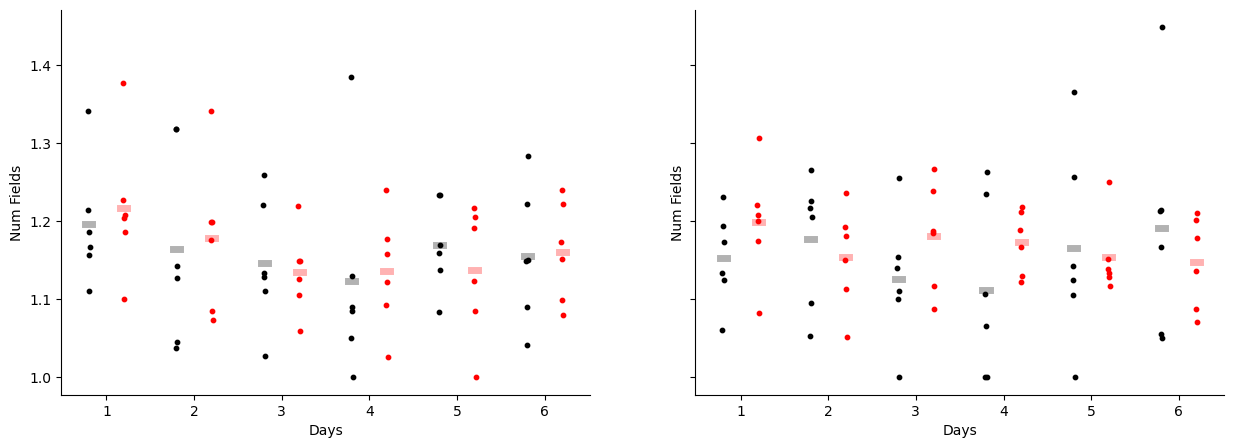

In [84]:
fig, ax = plt.subplots(1,2, figsize=[15,5],sharey=True)

s=10
lw =5
for day in range(6):
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s,alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Num Fields")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
    
# fig.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

-6.749336163504605 9.3292147232694e-06
-3.3343135813572675 0.0008551019694724832


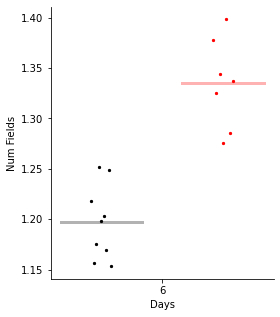

In [17]:
fig, ax = plt.subplots(figsize=[4,5],sharey=True)


day =5
mask = (df['ko']==0) & (df['day']==day) 
ctrl_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
ax.scatter(5*day-.3 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
ax.plot(5*day  -.3 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)

mask = (df['ko']==1) & (df['day']==day) 
ko_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
ax.scatter(5*day+.3 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
ax.plot(5*day  +.3 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)


t,p = sp.stats.ttest_ind(ctrl_frac,ko_frac)
print(t,p)
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
print(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("Num Fields")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))
    
fig.savefig(os.path.join(figdir,"num_sig_fields_summary_short.pdf"))

In [10]:
res = mixed_anova(data = df[df['nov']==0], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])
posthoc = pairwise_ttests(data = df[df['nov']==0], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse', padjust='holm')
print(posthoc)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.298594    1   14  0.298594  27.908340  0.000116  0.665938   
1          day  0.032943    5   70  0.006589   4.972955  0.000592  0.262108   
2  Interaction  0.008586    5   70  0.001717   1.296117  0.275539  0.084735   

        eps  
0       NaN  
1  0.677825  
2       NaN  
0.00011572197035229136
    Contrast  day    A    B Paired  Parametric         T        dof  \
0        day    -  0.0  1.0   True        True  2.709352  15.000000   
1        day    -  0.0  2.0   True        True  2.507658  15.000000   
2        day    -  0.0  3.0   True        True  2.799130  15.000000   
3        day    -  0.0  4.0   True        True  2.815911  15.000000   
4        day    -  0.0  5.0   True        True  3.708344  15.000000   
5        day    -  1.0  2.0   True        True  0.137195  15.000000   
6        day    -  1.0  3.0   True        True  0.619554  15.000000   
7        day    -  1.0  4.0   True  

In [29]:
res = mixed_anova(data = df[df['nov']==1], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.297436    1   14  0.297436  43.886574  0.000011  0.758148   
1          day  0.031782    5   70  0.006356   3.371559  0.008712  0.194085   
2  Interaction  0.011715    5   70  0.002343   1.242750  0.298618  0.081531   

        eps  
0       NaN  
1  0.589529  
2       NaN  
1.1423281353803488e-05


In [17]:
lmm_res = MixedLM(df['num_fields'], df[['ko', 
                                        'day', 
                                        'nov', 
                                        'ko_x_nov', 
                                        'ko_x_day',
                                        'nov_x_day',
                                        'speed',
                                        'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_fields
No. Observations: 192     Method:             REML      
No. Groups:       16      Scale:              0.0018    
Min. group size:  12      Log-Likelihood:     303.0512  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.038    0.017  2.330 0.020  0.006  0.071
day           -0.010    0.003 -2.844 0.004 -0.017 -0.003
nov           -0.100    0.015 -6.750 0.000 -0.130 -0.071
ko_x_nov      -0.001    0.012 -0.080 0.936 -0.025  0.023
ko_x_day       0.042    0.027  1.574 0.115 -0.010  0.094
nov_x_day      0.069    0.021  3.231 0.001  0.027  0.111
speed         -0.479    0.064 -7.507 0.000 -0.605 -0.354
intercept      1.417    0.022 63.896 0.00

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


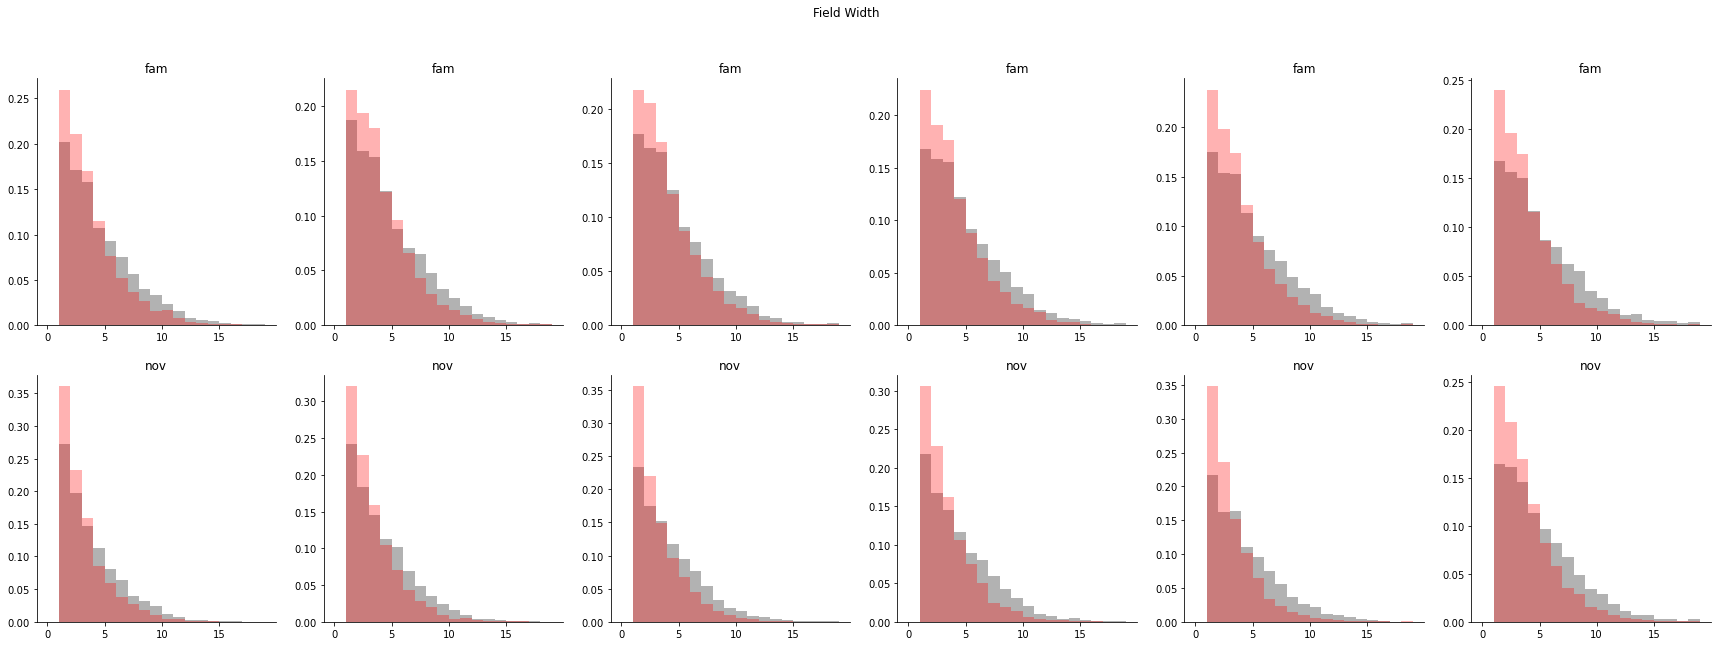

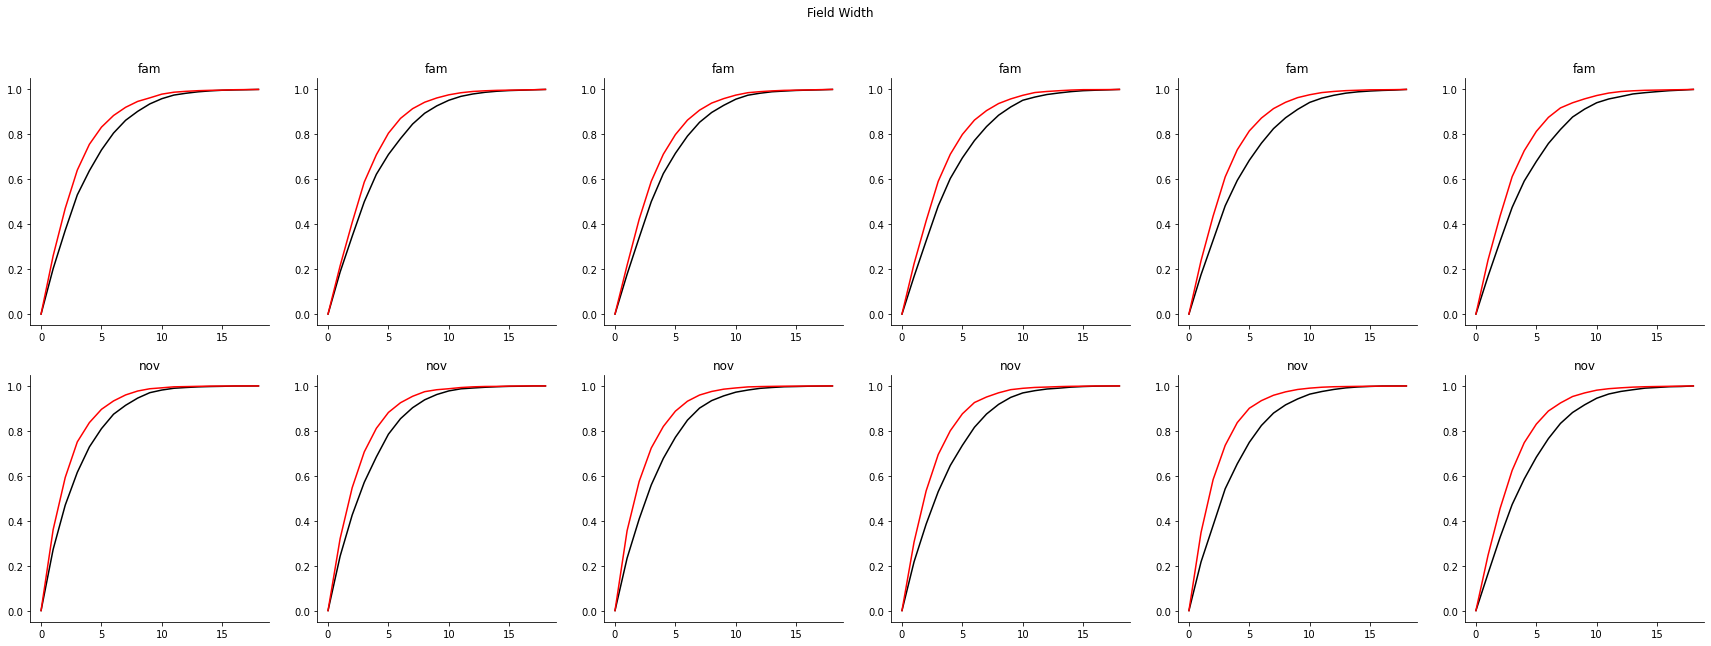

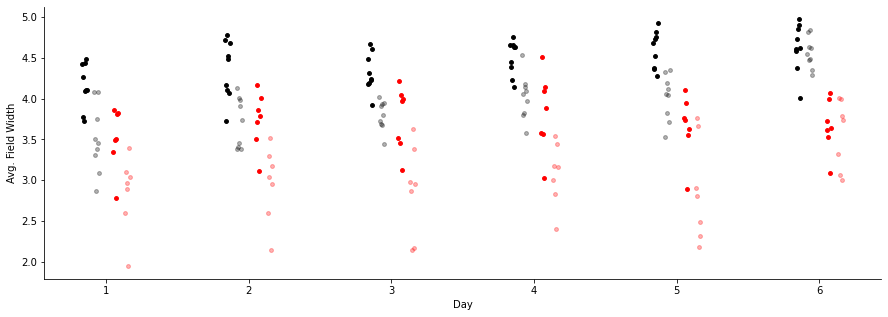

In [22]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize= [30,10])
fig_scat, ax_scat = plt.subplots( figsize= [15,5], sharey=True)
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'fw' : [],
                   'mouse': [],
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             print(dat)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': (day+1)/6.,
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        
        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(0,20), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             dat = ko_field_mask_res[mouse][day][novkey]['field_widths']
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': (day+1)/6., 
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

#         ax[row,day].hist(ko_fw, bins = np.arange(1,20), color = 'red', alpha = .3,density=True)
        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(0,20), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Field Width")
fig_cum.suptitle("Field Width")

ax_scat.set_ylabel('Avg. Field Width')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"field_width_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"field_width_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"field_width_summary.pdf"))
        

In [24]:
# _df = df[df['speed']>.05]
# _df['speed'] = sp.stats.zscore(df['speed']._values)
lmm_res = MixedLM(df['fw'],  df[['ko', 
                                 'day', 
                                 'nov', 
                                 'ko_x_nov', 
                                 'ko_x_day',
                                 'nov_x_day',
                                 'speed',
                                 'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fw      
No. Observations: 192     Method:             REML    
No. Groups:       16      Scale:              0.0509  
Min. group size:  12      Log-Likelihood:     -12.3144
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.100    0.089 -1.125 0.261 -0.275  0.075
day          0.366    0.136  2.700 0.007  0.100  0.632
nov         -0.756    0.080 -9.478 0.000 -0.912 -0.600
ko_x_nov    -0.162    0.066 -2.460 0.014 -0.290 -0.033
ko_x_day    -0.389    0.183 -2.123 0.034 -0.748 -0.030
nov_x_day    0.559    0.114  4.886 0.000  0.335  0.784
speed        3.943    0.400  9.851 0.000  3.158  4.727
intercept    2.889    0.138 20.935 0.000  2.619  3.160
day Var      0.080 

### Field edge analysis

In [122]:
def field_shifts(mouse, day, fm_res, novkey, pcnt_th = .25, act_th = .25, plot = False):
    chan = 'channel_0'
    ts_key = chan + '_F_dff'
    speed_key = chan + '_speed'
    sess = u.load_single_day(mouse,day)
    
    ledge, redge = fm_res[mouse][day][novkey]['rising_edges'], fm_res[mouse][day][novkey]['falling_edges']
    

    border_cells = (ledge[:,1]==0) + (redge[:,1]>=28) > 0
    ledge, redge = ledge[~border_cells,:], redge[~border_cells,:]
    
#     arm_cells = .5*(redge[:,0]+ledge[:,0])>=0 #10
#     ledge,redge = ledge[arm_cells,:], redge[arm_cells,:]
#     ledge[:,1], redge[:,1] = np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29) #np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29)

    if novkey in ['fam']:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
        
        
    shift = []
    form_lap_vel = []
    field_width = []
    form_lap = []
    field_var = []
    mean_speed = []
    relative_com = []
    for field in range(ledge.shape[0]):
        fieldmat = sess.trial_matrices[ts_key][trial_mask,:,:][:,np.maximum(ledge[field,1],0):redge[field,1],ledge[field,0]]
        speed = np.nanmean(sess.trial_matrices[speed_key][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
        fieldmat[np.isnan(fieldmat)]=1E-5
        activity_th = act_th*np.amax(fieldmat.ravel())
        fieldmat_th = np.amax(1*(fieldmat>activity_th), axis=1)
        formation_laps = fieldmat_th[:-4] * (sp.signal.convolve(fieldmat_th,np.ones([5,]), mode= 'valid')>=3) #(sp.ndimage.convolve1d(fieldmat_th, np.ones([5,]), mode='constant', cval = 0)>=1)
        if formation_laps.sum()>0:
            formation_lap = np.nonzero(formation_laps)[0][0]


            if fieldmat_th[formation_lap:].mean()>=pcnt_th and redge[field,1]-ledge[field,1]>=3: 


    #             form_lap_vel.append(np.nanmean(speed[np.maximum(formation_lap-1,0):formation_lap+2]))
                form_lap_vel.append(speed[formation_lap])
                mean_speed.append(np.nanmean(speed[formation_lap:]))
                form_lap.append(formation_lap)
                field_width.append(redge[field,1]-ledge[field,1])

                form_argmax = sp.ndimage.center_of_mass(fieldmat[formation_lap,:])[0] 
    #             form_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[np.maximum(formation_lap-1,0):formation_lap+2,:],axis=0))[0] 
    #             print(form_argmax, sp.ndimage.center_of_mass(fieldmat[formation_lap,:]))
                field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]
    #             field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+2:,:], axis=0))[0] 

                shift.append(field_argmax-form_argmax)
                com_vals = np.array([sp.ndimage.center_of_mass(fieldmat[trial,:])[0] for trial in range(formation_lap,formation_lap +5)])
                norm_com = com_vals - np.nanmean(com_vals[1:],keepdims = True)
                relative_com.append(norm_com)
                

                avg_act = np.nanmean(fieldmat[formation_lap:, :], axis=1)
                avg_act_norm = avg_act/np.nanmax(avg_act)
                field_var.append(np.nanvar(avg_act_norm))

                if plot:
                    fig, ax = plt.subplots(1,2, figsize= [10,5])
                    ax[0].imshow(sess.trial_matrices[ts_key][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                    ax[0].vlines([ledge[field,1], redge[field,1]], 0, trial_mask.sum(), color= 'blue')
#                     ax[0].hlines(formation_lap, 0,30)
                    ax[0].scatter(form_argmax+ ledge[field,1],formation_lap,color='white',marker='*',s=20)
    
    
                    trial_argmax = np.array([sp.ndimage.center_of_mass(fieldmat[trial,:])[0] for trial in range(formation_lap+1,fieldmat.shape[0])])
                    ax[0].scatter(trial_argmax+ledge[field,1], np.arange(formation_lap+1,fieldmat.shape[0]),color='white',marker='*',s=20)
                    ax[0].vlines(field_argmax + ledge[field,1], 0 , trial_mask.sum(), color='red')
                    ax[0].set_title("%d" % field)

                    ax[1].imshow(sess.trial_matrices[ts_key][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')

                    # mousedir = os.path.join(figdir, sess.mouse) 
                    # os.makedirs(mousedir, exist_ok = True)
#                     fig.savefig(os.path.join(mousedir, "field_%d.pdf" % field))

    return {'shift': np.array(shift), 
            'formation_lap': np.array(form_lap), 
            'width': np.array(field_width), 
            'init_speed': np.array(form_lap_vel),
            'speed': np.array(mean_speed),
            'field_var': np.array(field_var),
            'relative_com': np.vstack(relative_com)
           }

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


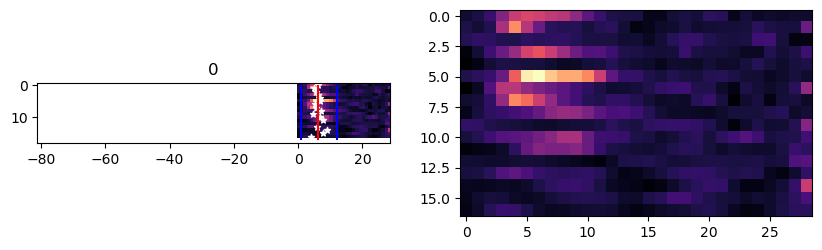

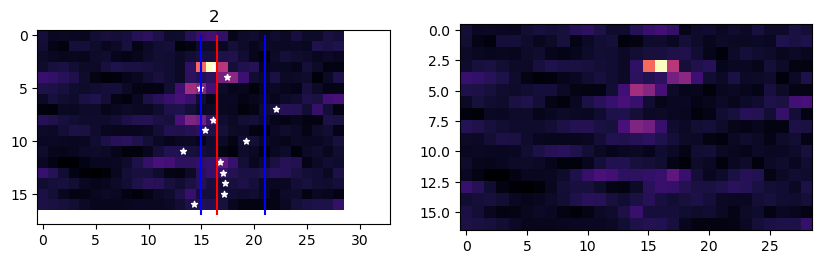

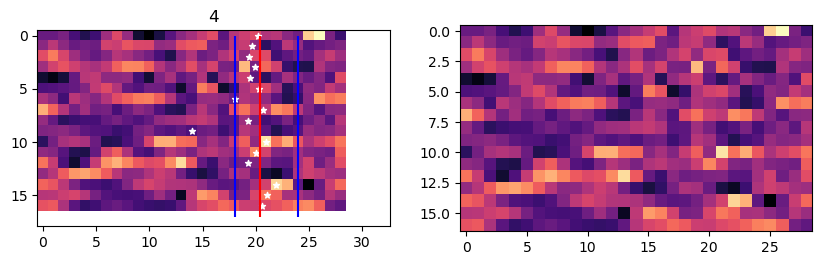

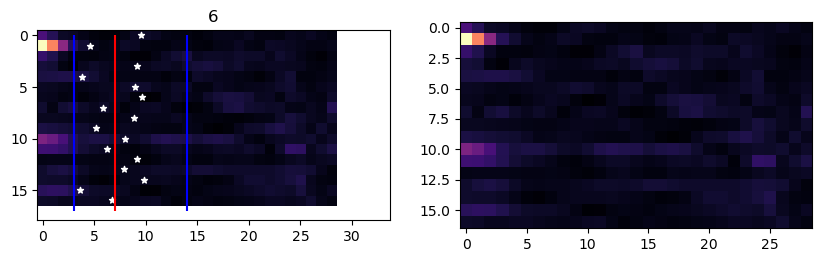

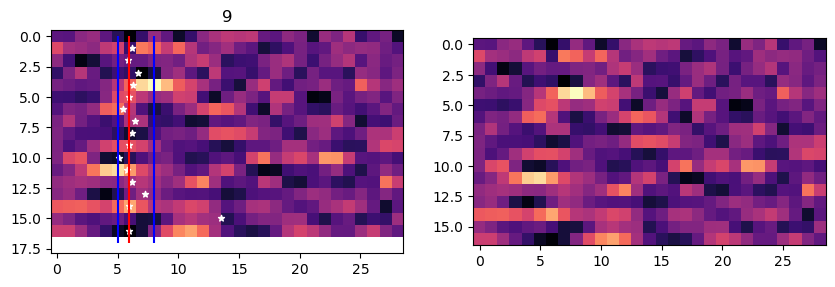

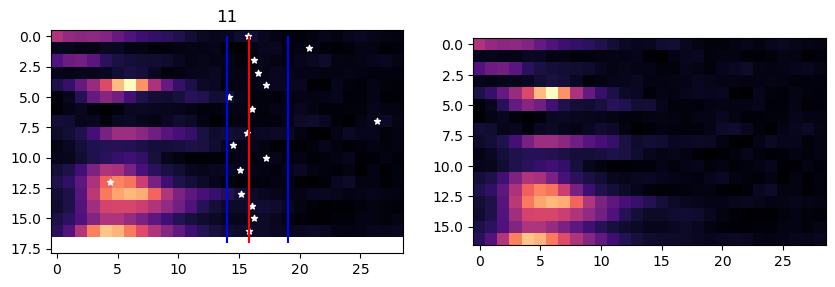

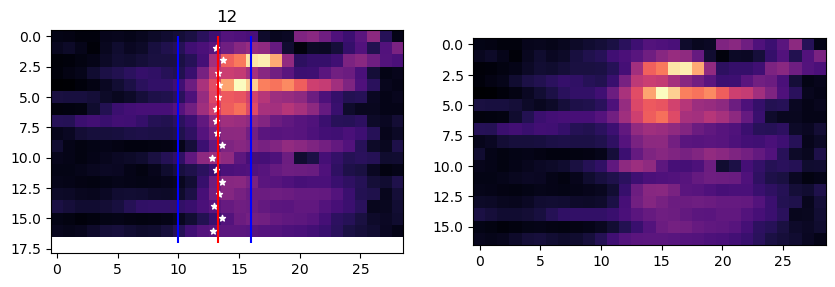

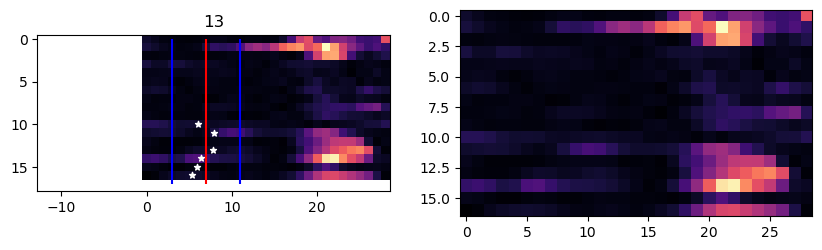

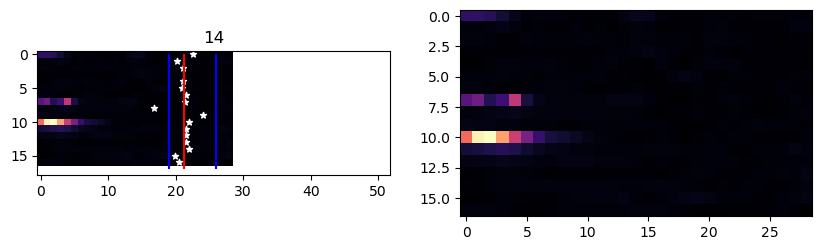

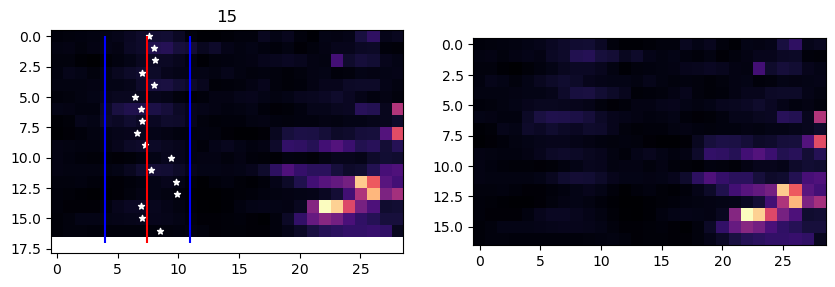

In [5]:

_ = field_shifts(sparse_mice[1], 0, ctrl_field_mask_res, 'nov', plot=True, act_th = .25, pcnt_th = .25)

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_87168\15188415.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2, figsize= [10,5])


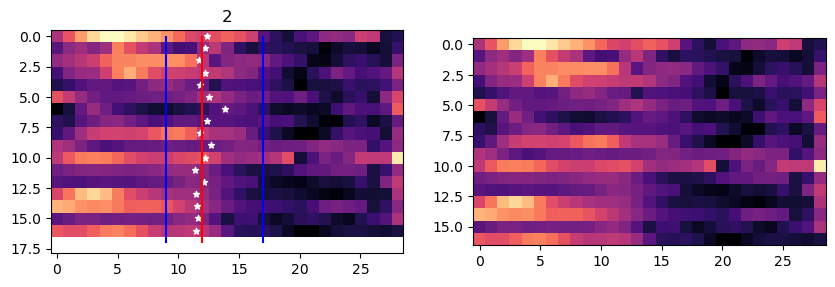

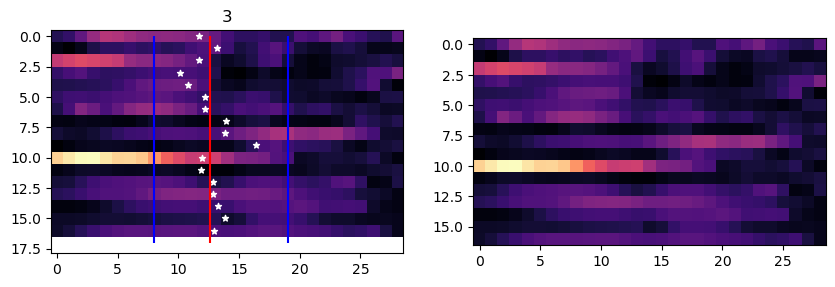

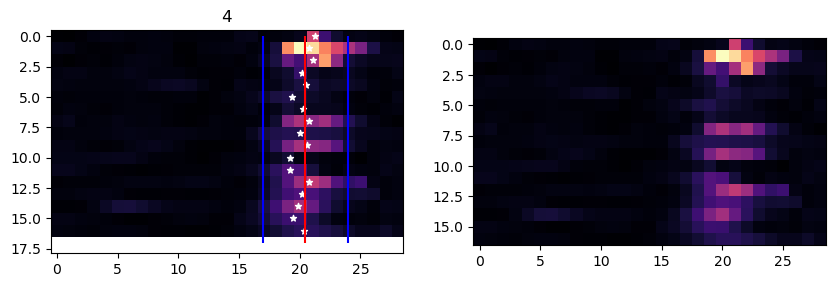

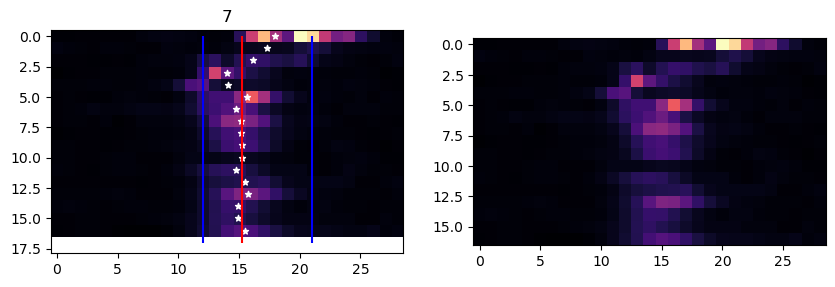

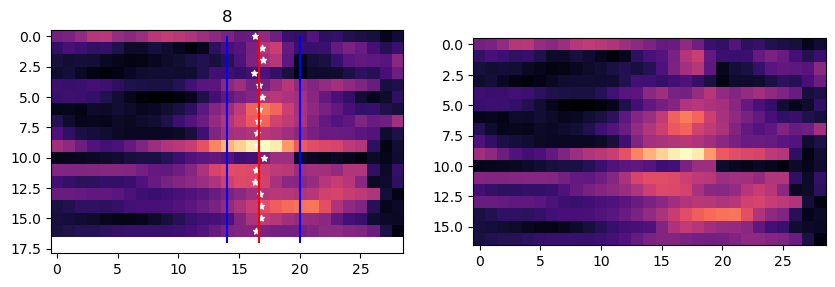

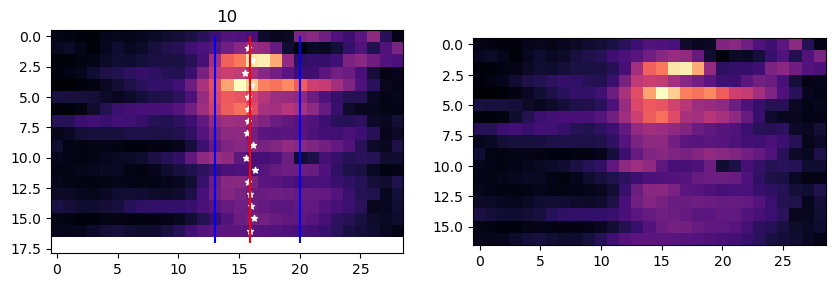

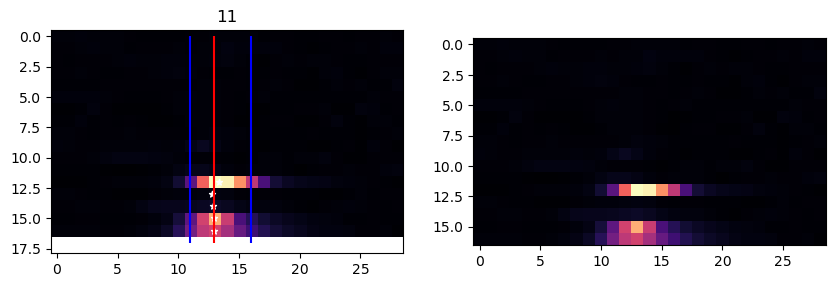

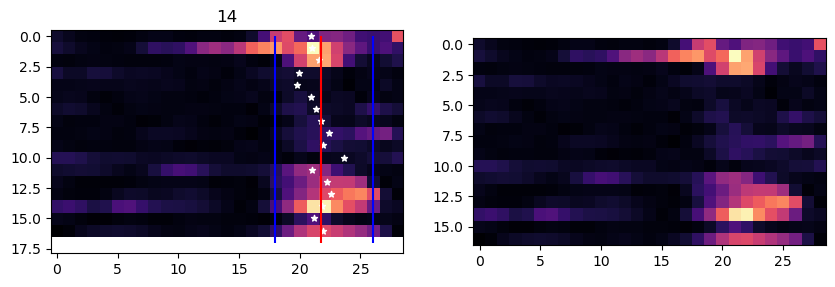

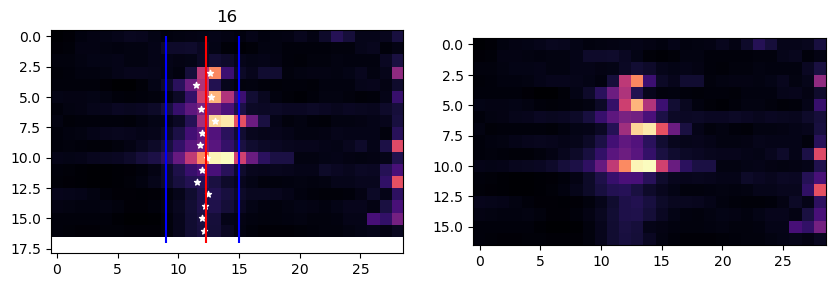

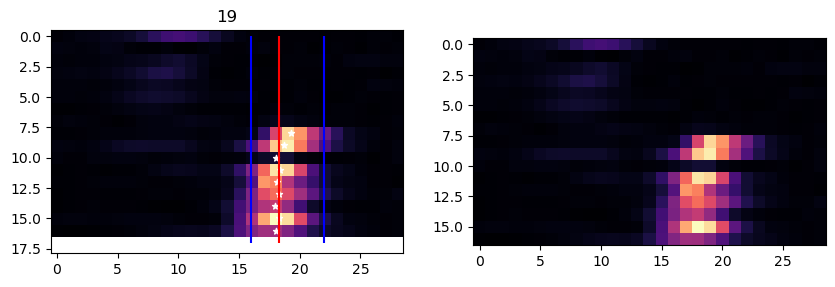

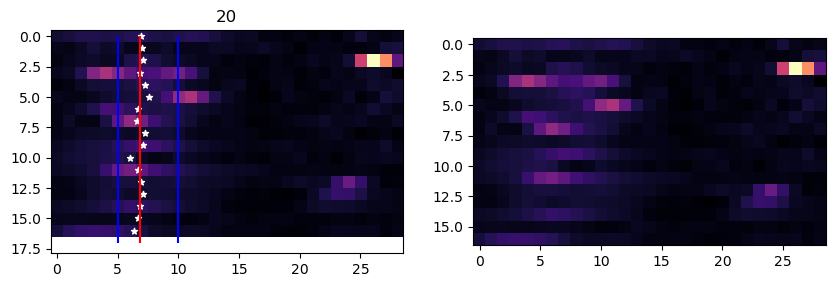

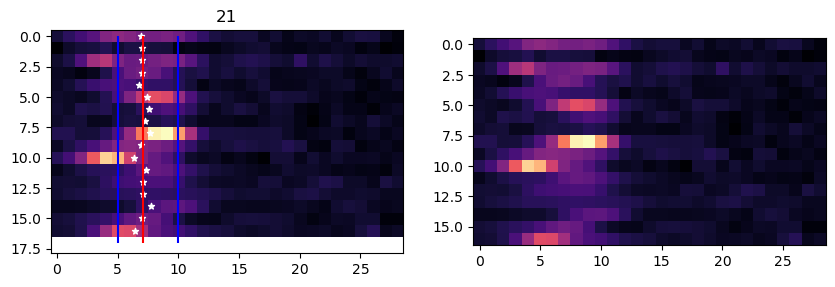

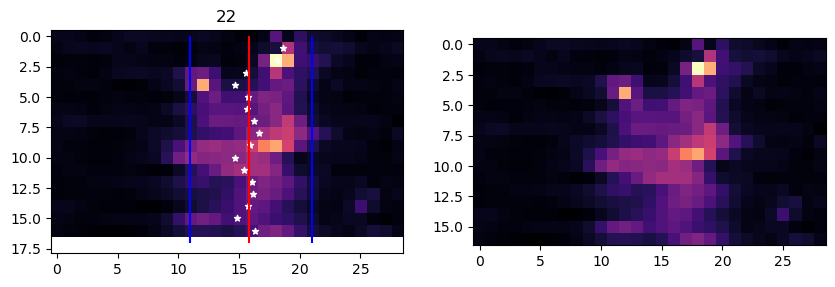

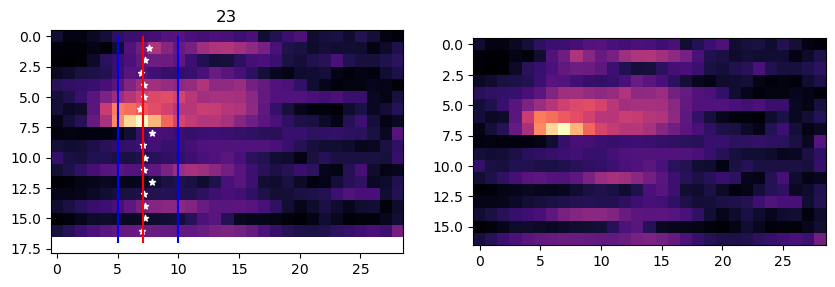

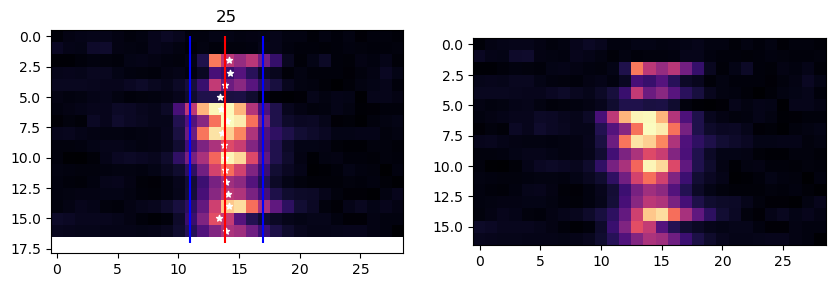

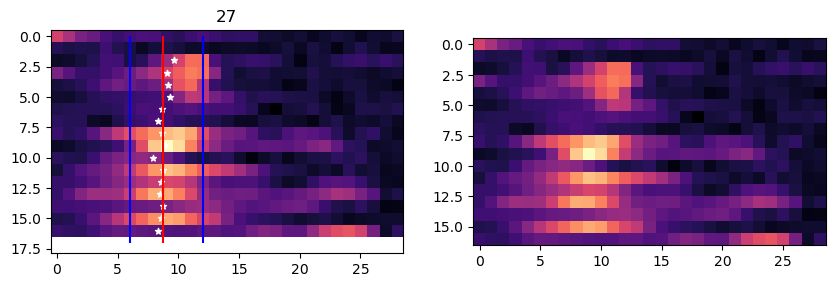

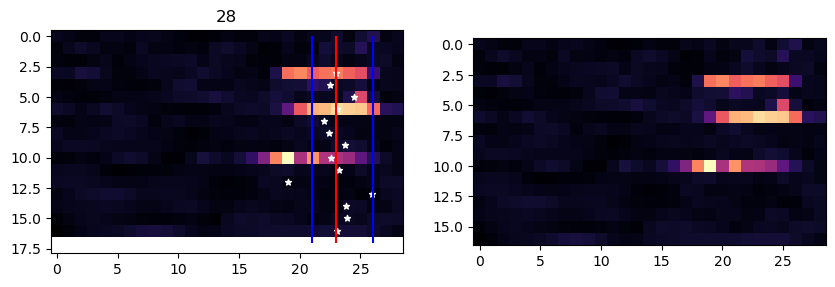

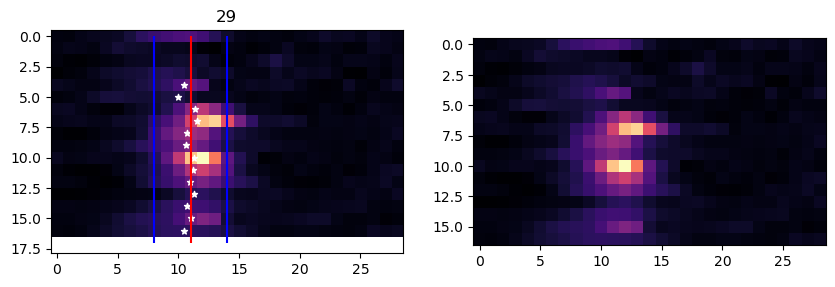

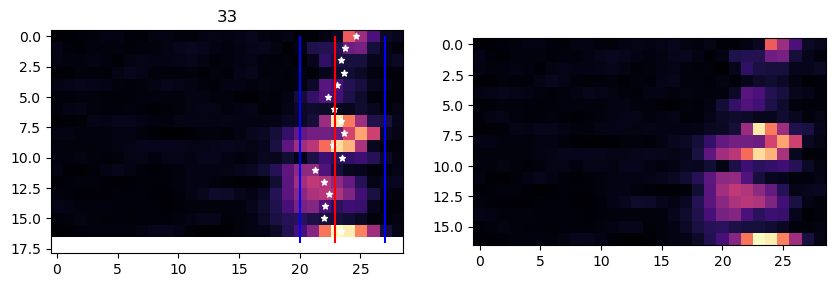

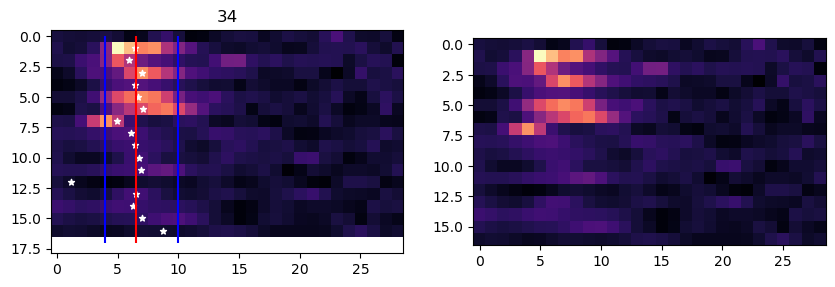

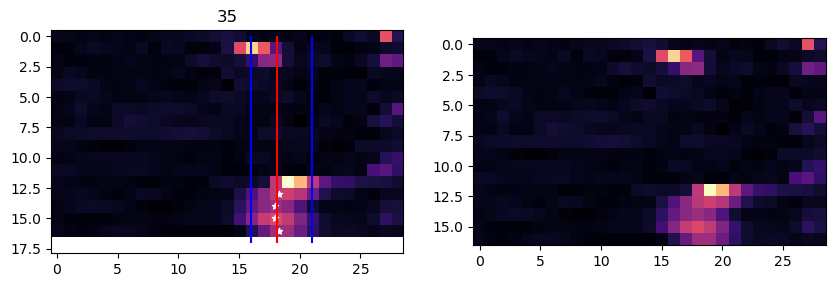

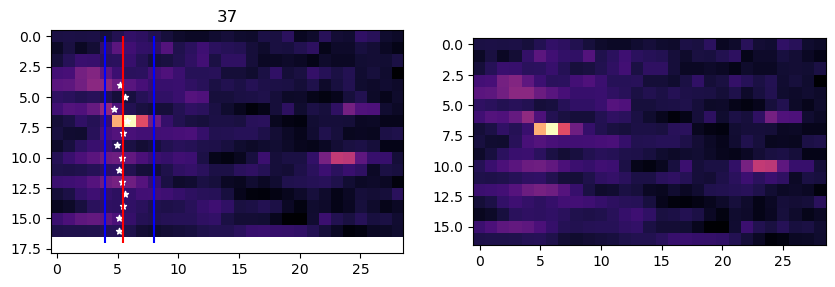

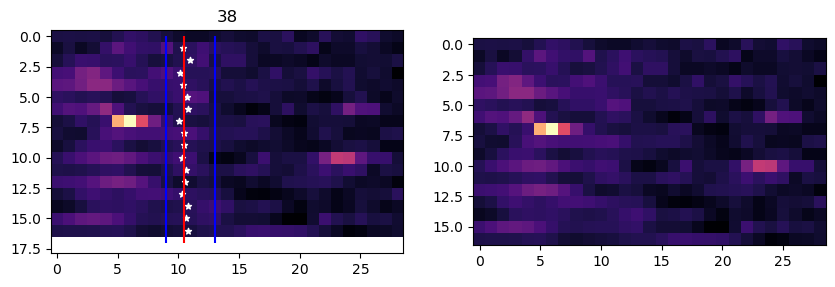

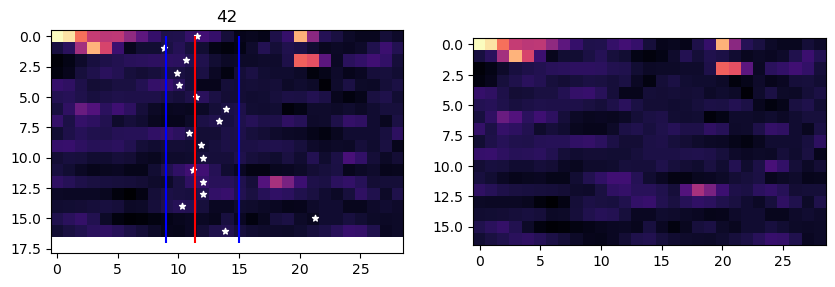

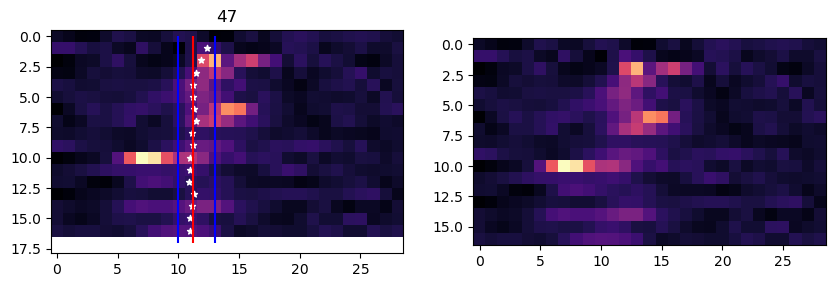

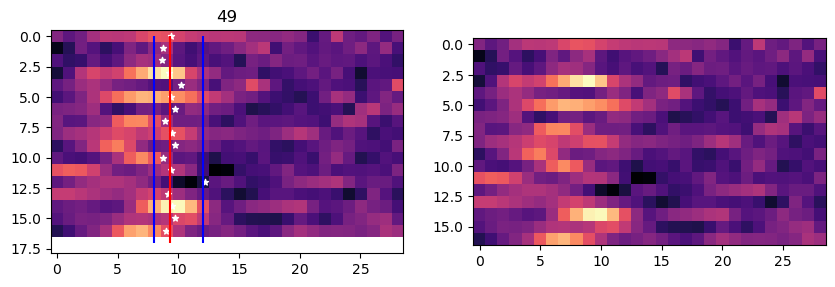

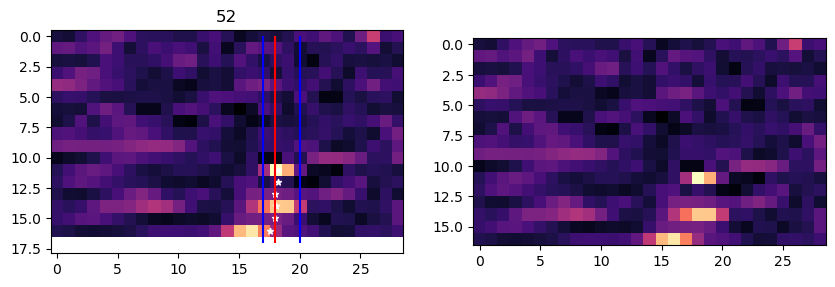

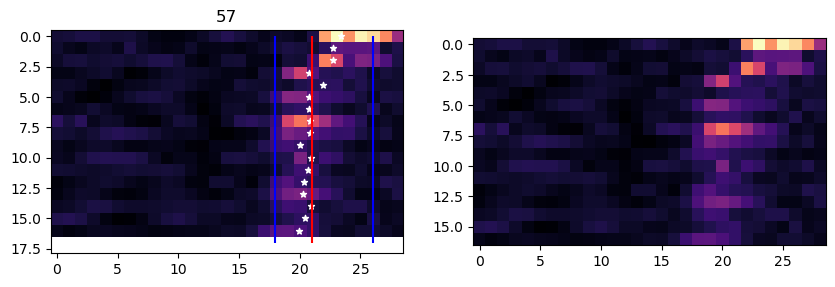

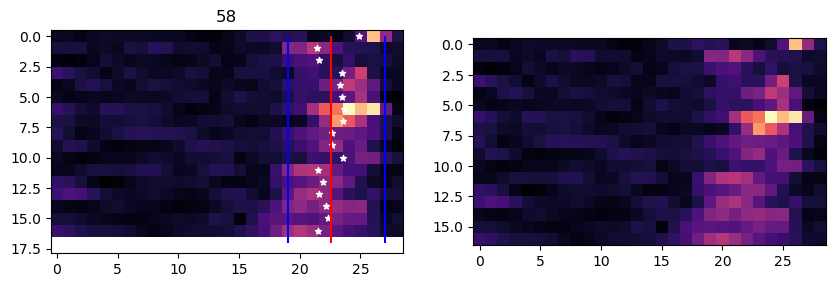

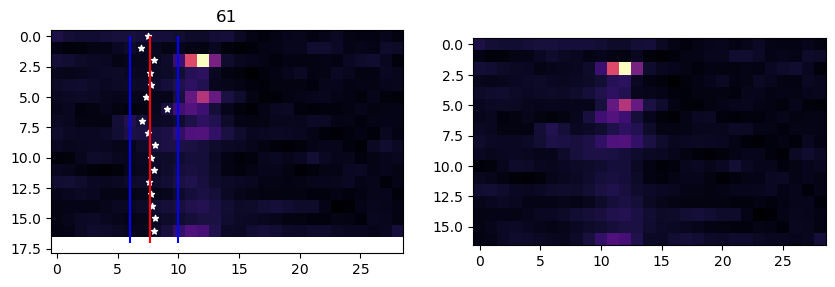

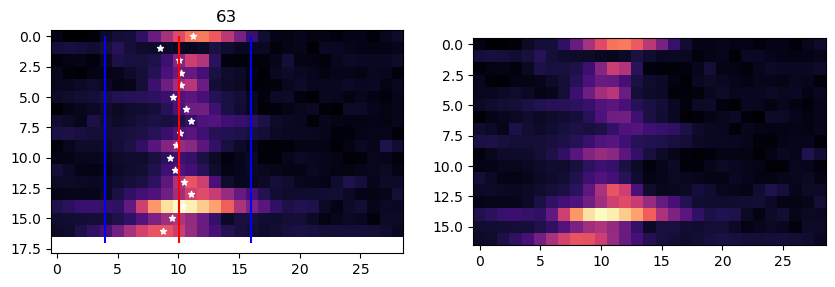

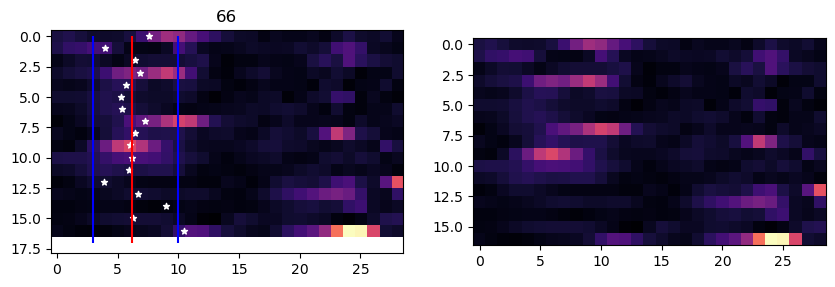

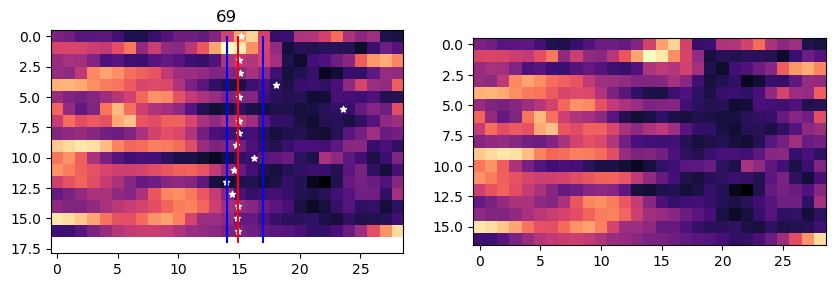

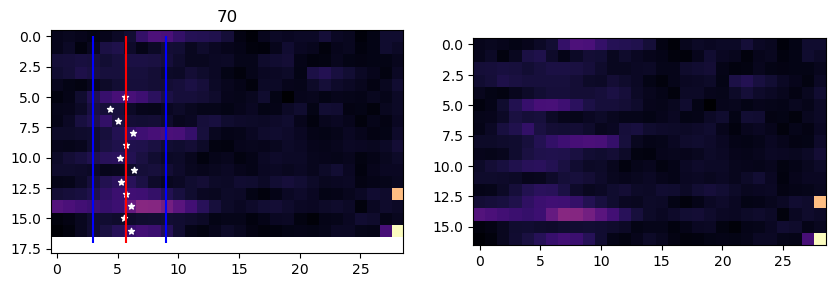

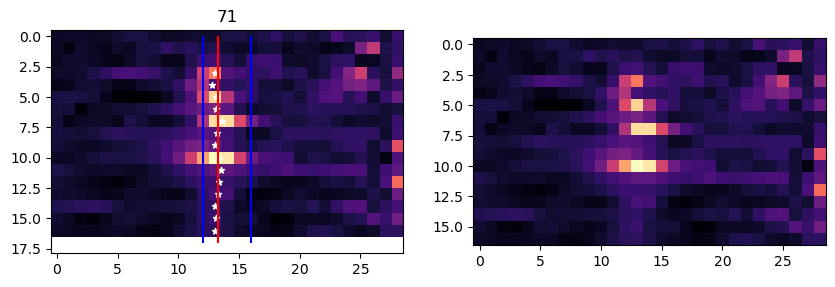

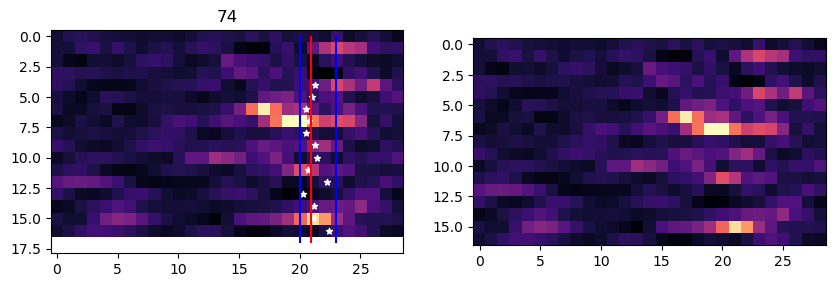

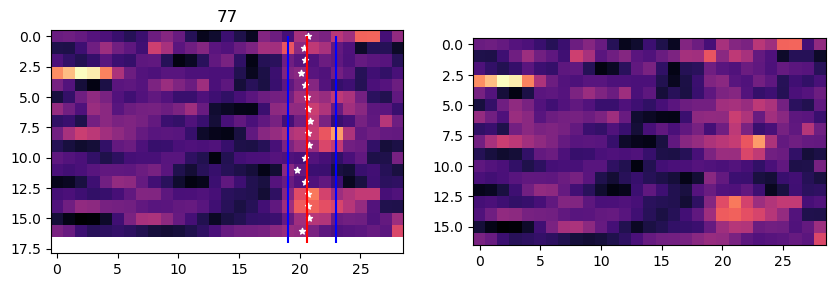

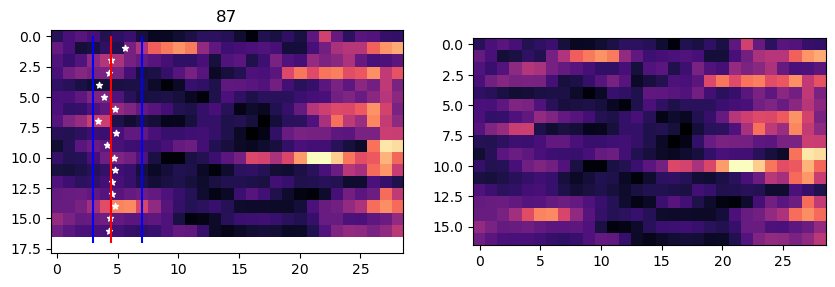

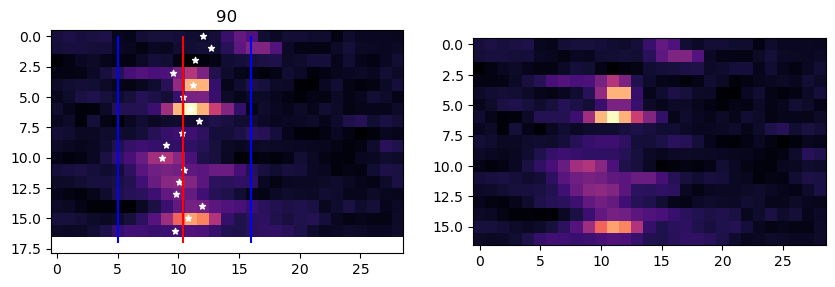

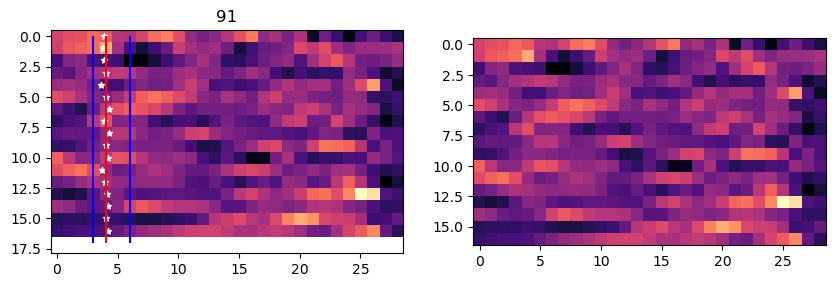

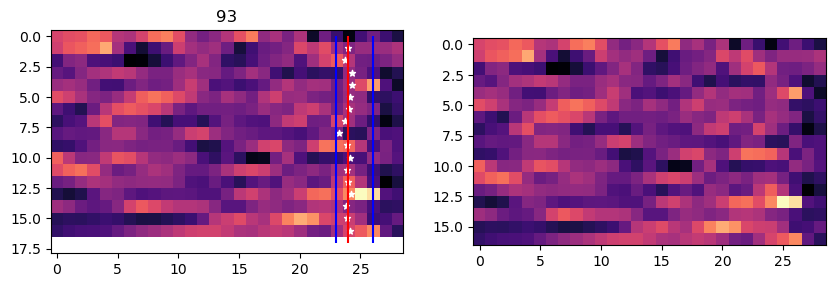

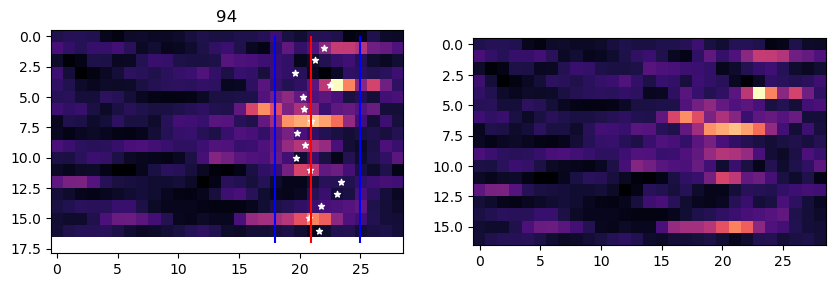

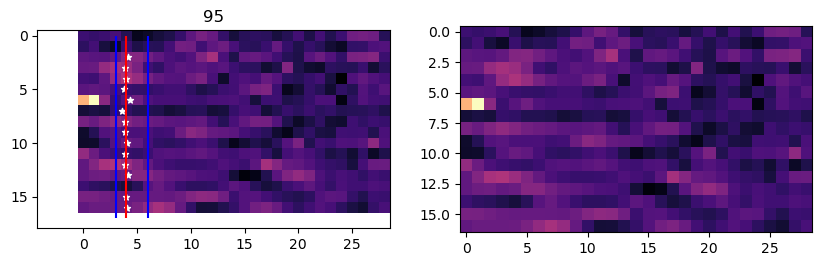

In [78]:
_ = field_shifts(sparse_mice[1], 0
                 , ko_field_mask_res, 'nov', plot=True, act_th=.25, pcnt_th=.25)

In [79]:
_

{'shift': array([-0.34372925,  0.88351704, -0.80488808, -2.69431415,  0.33453796,
         0.17556515, -0.42091731,  0.82530363, -0.34589095, -0.96134039,
        -0.08323173,  0.16721824, -2.79297098, -0.48660888, -0.34991266,
        -0.96022263,  0.05474208,  0.63534309, -1.70278548,  0.10438038,
        -0.89452494,  0.23064097,  0.13175736, -0.1390641 , -1.15487126,
        -0.08158819, -0.26012894, -2.38774008, -2.26823594,  0.23800081,
        -1.14670547, -1.37581931, -0.25127849,  0.13987961,  0.26997034,
        -0.31036164, -0.12972131, -1.17609322, -1.5834467 ,  0.15816587,
         0.01584838, -1.02987941,  6.70178581]),
 'formation_lap': array([ 0,  0,  0,  0,  0,  1, 12,  0,  3,  8,  0,  0,  1,  1,  2,  2,  3,
         4,  0,  1, 12,  4,  1,  0,  1,  0, 11,  0,  0,  0,  0,  0,  0,  5,
         3,  4,  0,  1,  0,  0,  1,  1,  0], dtype=int64),
 'width': array([ 8, 11,  7,  9,  6,  7,  5,  8,  6,  6,  5,  5, 10,  5,  6,  6,  5,
         6,  7,  6,  5,  4,  4,  6,  3,  4,  

In [121]:
ctrl_nov_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'nov', act_th = .25, pcnt_th = .25) for day in range(6)] for mouse in sparse_mice}
ctrl_fam_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'fam', act_th = .25, pcnt_th = .25) for day in range(6)] for mouse in sparse_mice}

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

In [123]:
ko_nov_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'nov', act_th = .25, pcnt_th = .25) for day in range(6)] for mouse in sparse_mice}
ko_fam_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'fam', act_th = .25, pcnt_th = .25) for day in range(6)] for mouse in sparse_mice}

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

In [25]:
df_shifts = pd.DataFrame({'mouse': [],
                          # 'chan':[],
                          'm': [],
                          'day': [],
                         'dz': [],
                         'ko': [],
                         'nov': [],
                         'nov_x_dz': [],
                         'ko_x_dz': [],
                         'ko_x_nov': [],
                         'ko_x_nov_x_dz':[],
                         'shifts': [],
                         'width': [],
                         'formation_lap': [],
                         'init_speed': [],
                         'init_speed_x_ko': [],
                         'speed': [],
                         'ko_x_speed': [],
                         'field_var': [],
                         'ko_x_speed': [], 
                         'intercept': [],
                         'relative_com': []})


days_z = sp.stats.zscore(np.arange(6))
for day, dz in enumerate(days_z):
    print('day', day)
    
    for m, mouse in enumerate(sparse_mice):

        # relcom_all = ctrl_nov_shifts[mouse][day]['relative_com']
        for _fn, (shift, width, init_speed, speed, formlap, fvar, relcom) in enumerate(zip(ctrl_nov_shifts[mouse][day]['shift'], 
                                                                                   ctrl_nov_shifts[mouse][day]['width'], 
                                                                                   ctrl_nov_shifts[mouse][day]['init_speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['formation_lap'],
                                                                                   ctrl_nov_shifts[mouse][day]['field_var'],
                                                                                   ctrl_nov_shifts[mouse][day]['relative_com'],
                                                                                   )):
            if np.isnan(shift)==0 and width <=17:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              #'chan': 'channel_1',
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 1,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': 0,
                                              'intercept': 1,
                                             'relative_com':  relcom}, ignore_index=True)

        # relcom_all = ctrl_fam_shifts[mouse][day]['relative_com']
        for _fn, (shift, width, init_speed, speed, formlap, fvar, relcom) in enumerate(zip(ctrl_fam_shifts[mouse][day]['shift'], 
                                                                                    ctrl_fam_shifts[mouse][day]['width'], 
                                                                                    ctrl_fam_shifts[mouse][day]['init_speed'],
                                                                                    ctrl_fam_shifts[mouse][day]['speed'],
                                                                                    ctrl_fam_shifts[mouse][day]['formation_lap'],
                                                                                    ctrl_fam_shifts[mouse][day]['field_var'],
                                                                                   ctrl_fam_shifts[mouse][day]['relative_com'],
                                                                                   )):
            if np.isnan(shift)==0 and width <=17:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              #'chan': 'channel_1',
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 0,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'speed': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1,
                                             'relative_com':  relcom}, ignore_index=True)

    for m, mouse in enumerate(sparse_mice):
        # relcom_all = ko_nov_shifts[mouse][day]['relative_com']
        for _fn, (shift, width, init_speed, speed, formlap, fvar,relcom) in enumerate(zip(ko_nov_shifts[mouse][day]['shift'], 
                                                                                    ko_nov_shifts[mouse][day]['width'], 
                                                                                    ko_nov_shifts[mouse][day]['init_speed'],
                                                                                    ko_nov_shifts[mouse][day]['speed'],
                                                                                    ko_nov_shifts[mouse][day]['formation_lap'],
                                                                                    ko_nov_shifts[mouse][day]['field_var'],
                                                                                   ko_nov_shifts[mouse][day]['relative_com'],
                                                                             )):
            if np.isnan(shift)==0  and width <=17:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              #'chan': 'channel_0',
                                              'm': m + len(sparse_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 1,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 1,
                                              'ko_x_nov_x_dz': 1,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': init_speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed,
                                              'intercept': 1,
                                             'relative_com':  relcom}, ignore_index=True)
                
        # relcom_all = ko_fam_shifts[mouse][day]['relative_com']        
        for _fn, (shift, width, init_speed, speed, formlap, fvar,relcom) in enumerate(zip(ko_fam_shifts[mouse][day]['shift'], 
                                                        ko_fam_shifts[mouse][day]['width'], 
                                                        ko_fam_shifts[mouse][day]['init_speed'],
                                                        ko_fam_shifts[mouse][day]['speed'],
                                                        ko_fam_shifts[mouse][day]['formation_lap'],
                                                        ko_fam_shifts[mouse][day]['field_var'],
                                                        ko_fam_shifts[mouse][day]['relative_com'],                                
                                                       )):
            if np.isnan(shift)==0 and width <=17:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              #'chan': 'channel_0',
                                              'm': m + len(sparse_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 0,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed, 
                                              'intercept': 1,
                                             'relative_com': relcom}, ignore_index=True)


{'shift': array([-0.45451669, -0.65242623,  1.58752523, -0.12401559,  0.15213918,
        -0.37465766, -0.62043455, -0.93805223,  0.43988376, -0.52334097,
        -0.43180176, -0.0053287 , -0.34227278, -0.19012333, -0.46970346,
        -0.27298716, -0.85600372, -0.37786245, -0.7105325 , -0.80029853,
         0.54669943, -0.58894145, -0.60325724, -0.34276011, -0.70958597,
        -0.93461466, -1.24249125, -0.18722487, -0.36503791, -1.02412598,
        -1.34069287,  0.16750741, -1.01229965, -0.6872075 , -0.89781893,
         0.02218885, -0.3084099 , -0.86909216, -0.32758857, -0.58520747,
        -0.31566001, -0.16581686, -0.23887154, -0.21491804, -1.23436318,
        -0.3735937 , -0.68629933,  0.31727705, -0.55307924, -0.65912239,
        -0.55738644, -1.55413136, -0.13221918, -0.71938587, -0.35525692,
        -0.39156006]),
 'formation_lap': array([1, 4, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 2, 0, 2, 3, 1, 5,
        2, 4, 1, 0, 0, 0, 5, 0, 2, 0, 1, 2, 1, 0, 5, 0, 5, 0, 1, 2, 5, 0,


In [108]:
sp.stats.zscore(np.arange(6))


array([-1.46385011, -0.87831007, -0.29277002,  0.29277002,  0.87831007,
        1.46385011])

In [125]:
df_shifts.shape

(6339, 15)

In [224]:
df_shifts.to_pickle("./df_shifts_dff.pkl")

In [2]:
df_shifts = pd.read_pickle("C:/Users/esay/data/Stx3/sparse_analyses/sig_fields/df_shifts_dff.pkl")

In [3]:
df_shifts.shape

(6339, 19)

-0.3352956486212146 0.7375241545699857
1.9261702991396685 0.05471129312124524
0.38772438728098313 0.6983548189098839
0.9566157399037986 0.3391990298445571
-0.8437335587452164 0.399166153602421
-1.8457853788425098 0.06554545569899077
0.5870657187541275 0.5574203823919899
2.2328591272331058 0.026016633065090163
-2.9308527491821135 0.003529584853824949
-1.8150610393258517 0.07009948726458458
-1.2392840796691424 0.21578674851479168
0.3261329876487553 0.7444498555129636


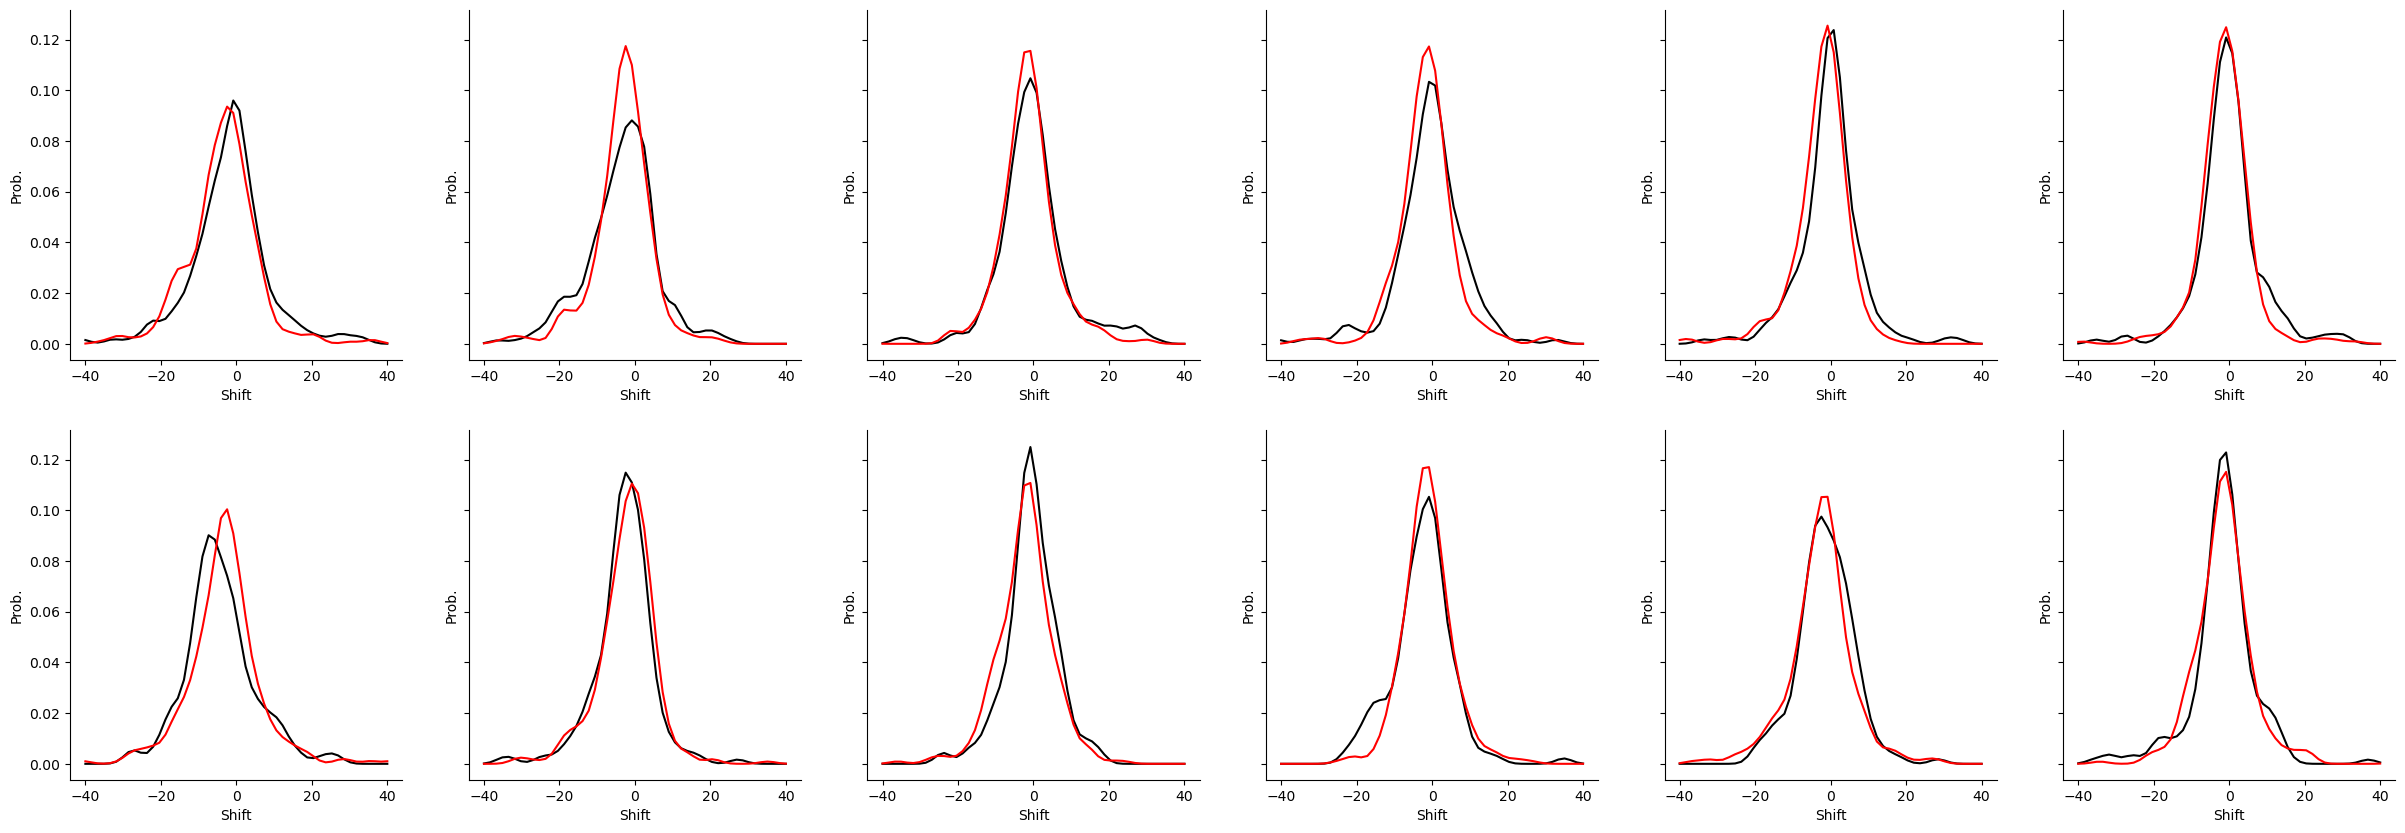

In [4]:
fig, ax = plt.subplots(2,6, figsize= [30,10], sharey=True)

x = np.linspace(-40,40)
for day in range(6):
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) &  (df_shifts['nov']==0) # & (df_shifts['speed']>0.05)
    ctrl_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='black')
#     ax[0,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1) & (df_shifts['nov']==0) # & (df_shifts['speed']>0.05)
    ko_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='red')
#     ax[0,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) & (df_shifts['nov']==1) # & (df_shifts['init_speed']>0.02)
    ctrl_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='black')
#     ax[1,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1)  & (df_shifts['nov']==1) #& (df_shifts['init_speed']>0.02)
    ko_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='red')
#     ax[1,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
for row in range(2):
    for col in range(6):
        ax[row,col].set_xlabel('Shift')
        ax[row,col].set_ylabel('Prob.')
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
    
# fig.savefig(os.path.join(figdir, "com_shift_by_day.pdf"), format = 'pdf')

In [6]:
aov = mixed_anova(data = df_shifts[ (df_shifts['day']<5)], dv = 'shifts', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.017885    1   10  0.017885  0.359130  0.562320        NaN   
1          day  0.803191    4   40  0.200798  4.627209  0.003645    0.03329   
2  Interaction  0.303473    4   40  0.075868  1.748316  0.158476        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.034668       NaN        NaN       NaN       NaN  
1  0.316343  0.427322      False  0.053137  0.001289  
2  0.148814       NaN        NaN       NaN       NaN  


C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


In [199]:
print(df_shifts[df_shifts['ko']==0].shape)
print(df_shifts[df_shifts['ko']==1].shape)

(2188, 19)
(4034, 19)


In [7]:

df = df_shifts[(df_shifts['speed']>0.01) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
                                  'dz', 
                                  'nov',
                                  'nov_x_dz', 
                                  'ko_x_dz', 
                                  'ko_x_nov', 
                                  'init_speed',  
                                  'init_speed_x_ko',
                                  'speed',
                                  'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
# print(lmm_resf.pvalues())

C:\Users\esay\AppData\Local\Temp\ipykernel_175616\200884843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\200884843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\200884843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: shifts    
No. Observations:   5262    Method:             REML      
No. Groups:         6       Scale:              0.9959    
Min. group size:    438     Log-Likelihood:     -7480.0798
Max. group size:    1498    Converged:          Yes       
Mean group size:    877.0                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.008    0.042 -0.200 0.841 -0.090  0.073
dz               0.109    0.033  3.332 0.001  0.045  0.174
nov             -0.054    0.049 -1.085 0.278 -0.150  0.043
nov_x_dz        -0.044    0.034 -1.302 0.193 -0.110  0.022
ko_x_dz         -0.041    0.035 -1.147 0.251 -0.110  0.029
ko_x_nov         0.015    0.059  0.254 0.799 -0.100  0.130
init_speed      -0.079    0.043 -1.850 0.064 -0.162  0.005
init_spe

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']==0)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
#                                   'dz', 
#                                   'nov',
#                                   'nov_x_dz', 
#                                   'ko_x_dz', 
#                                   'ko_x_nov', 
#                                   'init_speed',  
#                                   'init_speed_x_ko',
                                    'speed',
                                    'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts     
No. Observations: 11620   Method:             REML       
No. Groups:       16      Scale:              0.9823     
Min. group size:  264     Log-Likelihood:     -16413.5056
Max. group size:  1145    Converged:          Yes        
Mean group size:  726.2                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             -0.012    0.070 -0.177 0.859 -0.149  0.124
speed          -0.041    0.014 -2.940 0.003 -0.068 -0.014
ko_x_speed     -0.018    0.025 -0.693 0.488 -0.068  0.032
intercept       0.021    0.046  0.453 0.650 -0.069  0.110
Group Var       0.017    0.007                           



<ipython-input-13-b90cf43b57b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-13-b90cf43b57b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-13-b90cf43b57b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

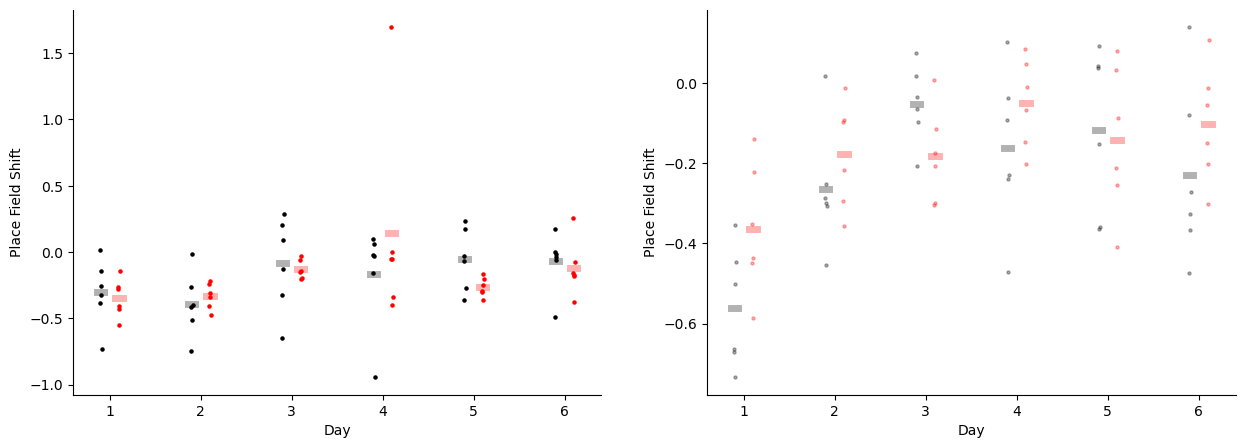

In [8]:
fig, ax = plt.subplots(1,2, figsize = [15,5], sharey=False)

plot_arr = np.zeros([2, 2, 6, 6 ])
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0) # & (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


    
for day in range(6):
    
    
    ax[0].scatter(5*day - .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,0,:,day], color = 'black', s = 5 )
    ax[0].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,0,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.275], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,0,:,day], nan_policy='omit')],width = .15, edgecolor='black', fill=False)
    
    ax[1].scatter(5*day -.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,1,:,day], color = 'black', s = 5 , alpha = .3)
    ax[1].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,1,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.075], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,1,:,day], nan_policy='omit')],width = .15, edgecolor='black',alpha = .3, fill=False)
    
    ax[0].scatter(5*day + .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,0,:,day], color = 'red', s = 5 )
    ax[0].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,0,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.125], [np.nanmean(plot_arr[1,0,:,day])],yerr = [sp.stats.sem(plot_arr[1,0,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = 1, fill=False)
    
    
    ax[1].scatter(5*day +.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,1,:,day], color = 'red', s = 5 , alpha = .3)
    ax[1].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,1,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.325], [np.nanmean(plot_arr[1,1,:,day])],yerr = [sp.stats.sem(plot_arr[1,1,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = .3, fill=False)
    
    
# ax.set_xticks(10*np.arange(6)+2)
# ax.set_xticklabels(np.arange(6))
for a in range(2):
    ax[a].set_xlabel('Day')
    ax[a].set_ylabel('Place Field Shift')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xticks(np.arange(0,26,5))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

C:\Users\esay\AppData\Local\Temp\ipykernel_190292\1273677306.py:17: RuntimeWarning: Mean of empty slice
  plot_arr[1,0,m,day]=np.nanmean(shifts)


IndexError: index 6 is out of bounds for axis 2 with size 6

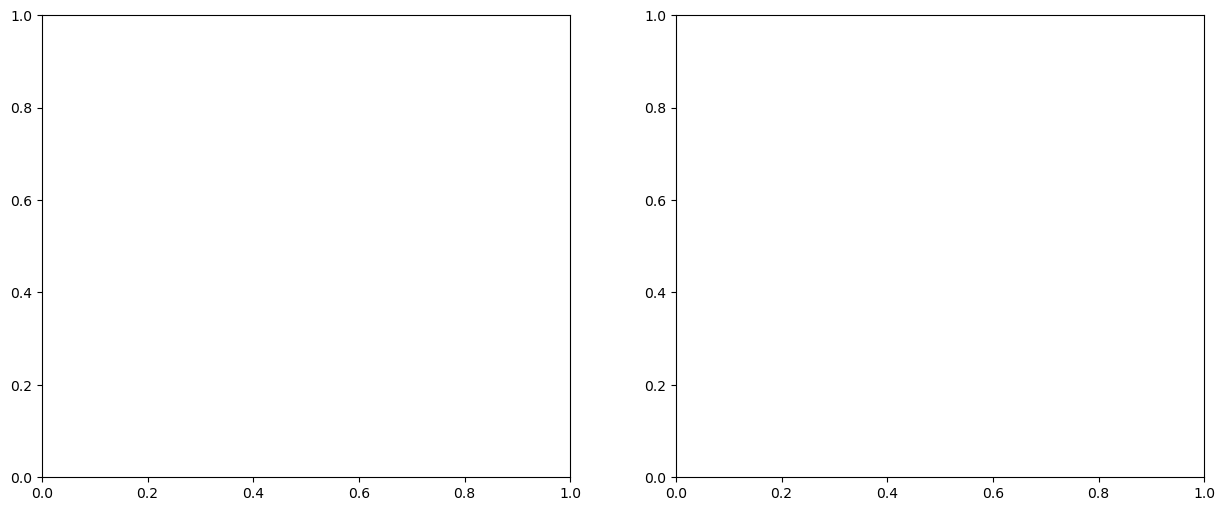

In [5]:
fig, ax = plt.subplots(1,2, figsize = [15,6], sharey=False)
plot_arr = np.zeros([2, 2, 6, 6 ])

for m, mouse in enumerate(sparse_mice[1:2]):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0) # & (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        # ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[1,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


for day in range(6):
    # For nov == 0 (ax[0])
    for m in range(plot_arr.shape[2]):
        x0 = 5 * day - 0.5 + np.linspace(-0.05, 0.05, num=plot_arr.shape[2])[m]
        x1 = 5 * day + 0.5 + np.linspace(-0.05, 0.05, num=plot_arr.shape[2])[m]
        y0 = plot_arr[0, 0, m, day]
        y1 = plot_arr[1, 0, m, day]
        if not np.isnan(y0) and not np.isnan(y1):
            ax[0].plot([x0, x1], [y0, y1], color='gray', alpha=0.3, linewidth=1)

    ax[0].scatter(5*day - .5 + np.linspace(-0.05, .05, num=plot_arr.shape[2]), plot_arr[0, 0, :, day], color='black', s=5)
    ax[0].plot(5*day - .5 + np.array([-.2, .2]), np.nanmean(plot_arr[0, 0, :, day])*np.ones([2, ]), color='black', linewidth=5, alpha=0.3)

    ax[0].scatter(5*day + .5 + np.linspace(-0.05, .05, num=plot_arr.shape[2]), plot_arr[1, 0, :, day], color='red', s=5)
    ax[0].plot(5*day + .5 + np.array([-.2, .2]), np.nanmean(plot_arr[1, 0, :, day])*np.ones([2, ]), color='red', linewidth=5, alpha=0.3)

    # For nov == 1 (ax[1])
    for m in range(plot_arr.shape[2]):
        x0 = 5 * day - 0.5 + np.linspace(-0.05, 0.05, num=plot_arr.shape[2])[m]
        x1 = 5 * day + 0.5 + np.linspace(-0.05, 0.05, num=plot_arr.shape[2])[m]
        y0 = plot_arr[0, 1, m, day]
        y1 = plot_arr[1, 1, m, day]
        if not np.isnan(y0) and not np.isnan(y1):
            ax[1].plot([x0, x1], [y0, y1], color='gray', alpha=0.3, linewidth=1)

    ax[1].scatter(5*day - .5 + np.linspace(-0.05, .05, num=plot_arr.shape[2]), plot_arr[0, 1, :, day], color='black', s=5, alpha=0.3)
    ax[1].plot(5*day - .5 + np.array([-.2, .2]), np.nanmean(plot_arr[0, 1, :, day])*np.ones([2, ]), color='black', linewidth=5, alpha=0.3)

    ax[1].scatter(5*day + .5 + np.linspace(-0.05, .05, num=plot_arr.shape[2]), plot_arr[1, 1, :, day], color='red', s=5, alpha=0.3)
    ax[1].plot(5*day + .5 + np.array([-.2, .2]), np.nanmean(plot_arr[1, 1, :, day])*np.ones([2, ]), color='red', linewidth=5, alpha=0.3)


In [142]:
plot_arr.shape

(2, 2, 6, 6)

In [10]:
df_aov = pd.DataFrame({'mouse':[] ,
                      'day': [],
                      'novel': [],
                      'ko': [],
                      'shift': [],})
for day in range(1):
    for m in range(len(sparse_mice)):
        
        df_aov = df_aov.append({'mouse': m,
                        'day': day,
                        'novel': 0,
                        'ko': 0,
                        'shift': plot_arr[0,0,m,day]}, ignore_index=True)
        
        df_aov = df_aov.append({'mouse': m,
                        'day': day,
                        'novel': 1,
                        'ko': 0,
                        'shift': plot_arr[0,1,m,day]}, ignore_index=True)
        
    for m in range(len(sparse_mice)):
        
        df_aov = df_aov.append({'mouse': m+len(sparse_mice),
                        'day': day,
                        'novel': 0,
                        'ko': 1,
                        'shift': plot_arr[1,0,m,day]}, ignore_index=True)
        
        df_aov = df_aov.append({'mouse': m+len(sparse_mice),
                        'day': day,
                        'novel': 1,
                        'ko': 1,
                        'shift': plot_arr[1,1,m,day]}, ignore_index=True)

C:\Users\esay\AppData\Local\Temp\ipykernel_175616\4260815564.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aov = df_aov.append({'mouse': m,
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\4260815564.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aov = df_aov.append({'mouse': m,
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\4260815564.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aov = df_aov.append({'mouse': m,
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\4260815564.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aov = df_aov.append({'mouse': m,
C:\Users\esay\AppData\Local\Temp\ipykernel_175

In [11]:
aov = mixed_anova(data = df_aov[ (df_aov['novel']==1) & (df_aov['day']<5)], dv = 'shift', between = 'ko', within= 'day', subject = 'mouse')
print(aov)

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:569: RuntimeWarning: invalid value encountered in scalar divide
  ms_with = ss_with / ddof1
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:570: RuntimeWarning: invalid value encountered in scalar divide
  ms_reswith = ss_reswith / ddof2


KeyError: 'MS'

In [9]:
for day in range(6):
    print("day %d" % day)
    print("fam")
    t,p = sp.stats.ttest_rel(plot_arr[0,0,:,day],plot_arr[1,0,:,day], nan_policy = 'omit')
    print("ko v control",t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[0,0,:,day],0)
    print("control", t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[1,0,:,day],0)
    print("ko", t,p)

day 0
fam
ko v control 5.979027017798981 0.0018752850972859562
control 1.0 0.36321746764912255
ko -5.8894781631876665 0.0020059889029154804
day 1
fam
ko v control 1.7812806163617165 0.13497211989209246
control -0.9999999999999999 0.36321746764912255
ko -8.347180758540157 0.0004036803687790312
day 2
fam
ko v control 0.21873978302647626 0.8355009814240726
control -1.0 0.36321746764912255
ko -4.543166926690493 0.006150836636599598
day 3
fam
ko v control -0.4563714102346925 0.6672621519100873
control -1.0 0.36321746764912255
ko 0.44910767250593897 0.672150676463288
day 4
fam
ko v control 3.3026998778354653 0.02141174503814013
control -1.0 0.36321746764912255
ko -8.922007844545387 0.0002946070644733482
day 5
fam
ko v control 0.3257060647723067 0.7578358330153165
control -1.0 0.36321746764912255
ko -1.383657827655211 0.22504944416006073


In [10]:
pvals=[]
for day in range(6):
    print("day %d" % day)
    print("nov")
    t,p = sp.stats.ttest_rel(plot_arr[0,1,:,day],plot_arr[1,1,:,day])#, nan_policy = 'omit')
    pvals.append(p)
    print("ko v control",t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[0,1,:,day],0)
    print("control", t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[1,1,:,day],0)
    print("ko", t,p)

day 0
nov
ko v control -3.084210002180503 0.027338562198990828
control -9.176483061652558 0.00025774696588121366
ko -5.49032627822832 0.0027361400689698144
day 1
nov
ko v control -1.1539776157121435 0.300668470134388
control -4.182889633312379 0.008630828728155378
ko -3.2794268485129314 0.02196843101653605
day 2
nov
ko v control 1.9939485838475128 0.10273044225572787
control -1.303237881763955 0.24927631178010645
ko -3.7629963744142527 0.01311702539075261
day 3
nov
ko v control -2.0905778737514327 0.09083318114734336
control -1.9784964217412495 0.10477932821601467
ko -1.0644388257042232 0.3358107689349982
day 4
nov
ko v control 0.2835298131488748 0.7881357620785441
control -1.3874718625385727 0.2239570482332382
ko -1.8604569166347742 0.12189917984397443
day 5
nov
ko v control -1.2008397863915132 0.28359280618667587
control -2.5230129620039747 0.05297951417706577
ko -1.7049260052142257 0.14892802926400442


In [145]:
pvals

[0.027338562198990828,
 0.300668470134388,
 0.10273044225572787,
 0.09083318114734336,
 0.7881357620785441,
 0.28359280618667587]

In [11]:
df = df_shifts[(df_shifts['nov']==1) & (df_shifts['day']==0)]

In [15]:
import pingouin as pg
pvals = []
for day in range(5):
    df = df_shifts[(df_shifts['nov']==1) & (df_shifts['day']==day)]
    ttest = pg.pairwise_tests(data=df, dv='shifts', between='ko', subject='m', padjust='holm', marginal=False)
    pvals.append(ttest['p-unc'].iloc[0])
print(pvals)

[0.07355127052759126, 0.3423572030286942, 0.035126186672825, 0.039328901484587446, 0.05669922388176932]


In [146]:
pg.multicomp(pvals=pvals)

(array([False, False, False, False, False, False]),
 array([0.16403137, 0.85077842, 0.45416591, 0.45416591, 0.85077842,
        0.85077842]))

In [16]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['field_var'] = sp.stats.zscore(df['field_var']._values)
lmm_res = MixedLM(df['field_var'], df[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov',  'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

C:\Users\esay\AppData\Local\Temp\ipykernel_169144\126645462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\126645462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\126645462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var 
No. Observations: 4873    Method:             REML      
No. Groups:       6       Scale:              0.9287    
Min. group size:  438     Log-Likelihood:     -6756.5759
Max. group size:  1275    Converged:          Yes       
Mean group size:  812.2                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.202    0.041  4.901 0.000  0.121  0.283
dz             0.037    0.032  1.136 0.256 -0.027  0.100
nov            0.542    0.049 11.062 0.000  0.446  0.638
nov_x_dz      -0.034    0.033 -1.012 0.311 -0.099  0.032
ko_x_dz        0.000    0.035  0.002 0.998 -0.069  0.069
ko_x_nov      -0.103    0.059 -1.763 0.078 -0.218  0.012
intercept     -0.311    0.067 -4.648 0.000 -0.443 -0.180
Group Var      0.020    0.014            

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [17]:
aov = mixed_anova(data = df[df['nov'] == 0], dv = 'field_var', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.466252    1   10  0.466252  0.649139  0.439159        NaN   
1          day  0.719409    4   40  0.179852  2.723156  0.042735   0.072775   
2  Interaction  0.045970    4   40  0.011493  0.174009  0.950455        NaN   

        np2      eps sphericity   W-spher   p-spher  
0  0.060957      NaN        NaN       NaN       NaN  
1  0.214031  0.50643      False  0.120176  0.019871  
2  0.017103      NaN        NaN       NaN       NaN  


C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


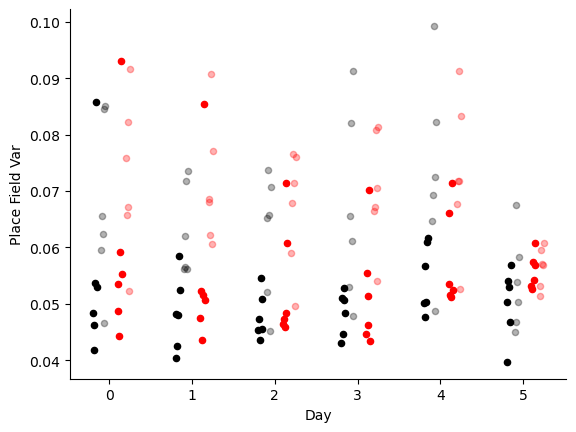

In [18]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 6, 6 ])
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Var')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.savefig(os.path.join(figdir, "field_var_summary.pdf"))

In [30]:
df = df_shifts[(df_shifts['speed']>0.01) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)

lmm_res = MixedLM(df['width'], df[['ko', 
                                 'dz', 
                                 'nov',
                                 'nov_x_dz', 
                                 'ko_x_dz', 
                                 'ko_x_nov', 
                                 'init_speed',  
                                 'init_speed_x_ko', 
                                 'speed', 
                                 'ko_x_speed',
                                 'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-30-66aa9be0e033>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-30-66aa9be0e033>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-30-66aa9be0e033>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: width       
No. Observations:  65767   Method:             REML        
No. Groups:        16      Scale:              6.7574      
Min. group size:   1633    Log-Likelihood:     -156210.4981
Max. group size:   5953    Converged:          Yes         
Mean group size:   4110.4                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko              -0.079    0.284  -0.277 0.782 -0.636  0.479
dz              -0.062    0.019  -3.254 0.001 -0.100 -0.025
nov             -0.414    0.028 -14.609 0.000 -0.470 -0.359
nov_x_dz         0.073    0.026   2.739 0.006  0.021  0.124
ko_x_dz         -0.021    0.026  -0.825 0.409 -0.072  0.029
ko_x_nov        -0.054    0.044  -1.230 0.219 -0.141  0.032
init_speed      -0.053    0.019  -2.744 0.006 -0.09

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


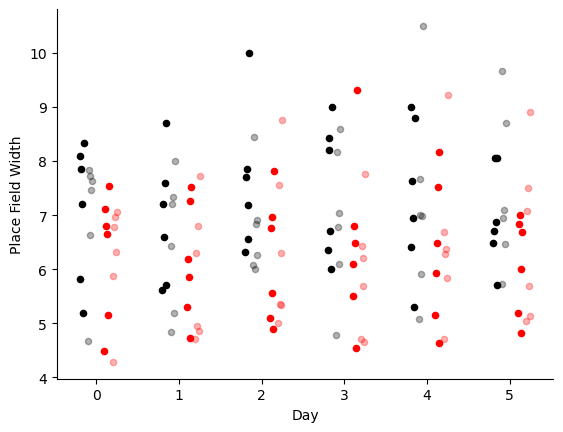

In [13]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 6, 6 ])
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

0.3261329876487553 0.7444498555129636
0.3261329876487553 0.7444498555129636


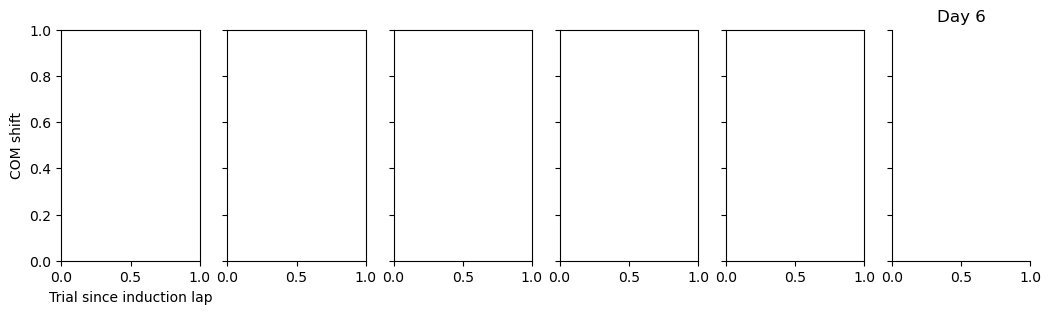

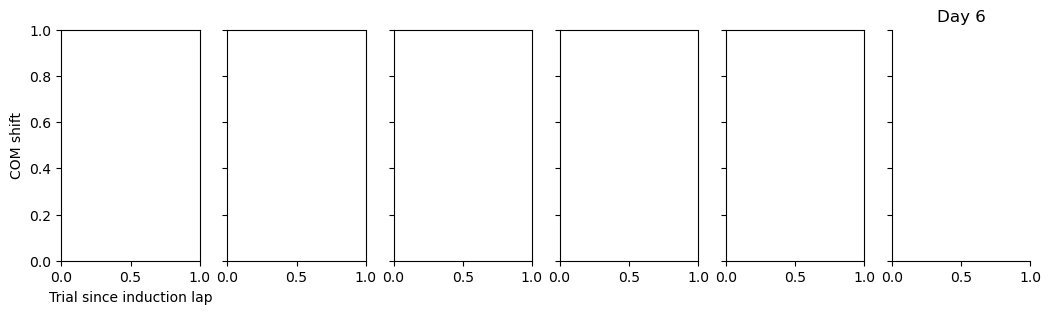

In [14]:

max_trial=140 #5
plot_max = 5
# ttype = 'nov'
df = {'mouse': [], 'cond':[], 'day':[], 'shift':[], 'nov':[]}
for ttype in ('fam', 'nov'):
    fig, ax = plt.subplots(1,6, sharey=True, figsize=[12.5,3])
    # com = []
    # ctrl_com = np.nan*np.zeros((len(ctrl_mice),max_trial))
    ctrl_com = []
    df_ctrl = df_shifts[df_shifts['ko']==0]
    ctrl_com = 10*df_ctrl['shifts']
    speed =100*df_ctrl['speed']

    df['mouse'] = df_ctrl['mouse']
    df['cond']=df_ctrl['ko']
    df['day'] = df_ctrl['day']
    
    df['shift'] = 10*np.nanmean(ctrl_com)
    df['nov'] = df_ctrl['nov']

       

            
    ctrl_com = np.array(ctrl_com)
    mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')           
    # ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='black', alpha=.3) 

        # # com = []
        # # ko_com = np.nan*np.zeros((len(ko_mice), max_trial))
        # ko_com=[]
        # for m, mouse in enumerate(ko_mice):
        #     _com = field_stats[mouse][day][ttype]['com']
            
        #     field_info = np.array(field_stats[mouse][day][ttype]['field_info']) 
        #     mask = field_info[:,1]>0
            
        #     _com = (_com[:, mask] - np.nanmean(_com[1:,:][:,mask], axis=0,keepdims=True))
            
        #     for c in range(_com.shape[1]):
        #         _ko_com = np.nan*np.zeros((max_trial,))
        #         _ko_com[:_com.shape[0]] = 10*_com[:,c]
        #         ko_com.append(_ko_com)
            
        #     # ko_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)

        #     df['mouse'].append(mouse)
        #     df['cond'].append('cre')
        #     df['day'].append(day)
            
        #     df['shift'].append(10*np.nanmean(_com[0,:]))
        #     df['nov'].append(ttype)


            


        # ko_com = np.array(ko_com)
        # mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')           
        # ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='red', alpha=.3) 


    ax[day].spines['top'].set_visible(False)
    ax[day].spines['right'].set_visible(False)
    ax[day].set_title(f'Day {day+1}')


    # t, p = sp.stats.ttest_ind(ko_com[:, 0], ctrl_com[:,0])
    print(t,p)

    ax[0].set_ylabel('COM shift')
    ax[0].set_xlabel('Trial since induction lap')
        

# fig.savefig(os.path.join(figdir, f"single_field_COM_shift_maxtrial_{plot_max}_ttype_{ttype}.pdf"))
df = pd.DataFrame(df)

In [45]:
t,p = sp.stats.ttest_ind(plot_arr[0,0,:,0],plot_arr[1,0,:,0])
print(t,p)

2.2204814538609745 0.041175546614633574


-0.7968966012204717 0.4258394317132871
-2.8829320199141613 0.004078271094623399
-3.213006905886893 0.0013863904270502395
-2.795622913047524 0.005376085058201336
-2.2855817517332255 0.02268183980254798
-3.554372309609717 0.00041261508686977707


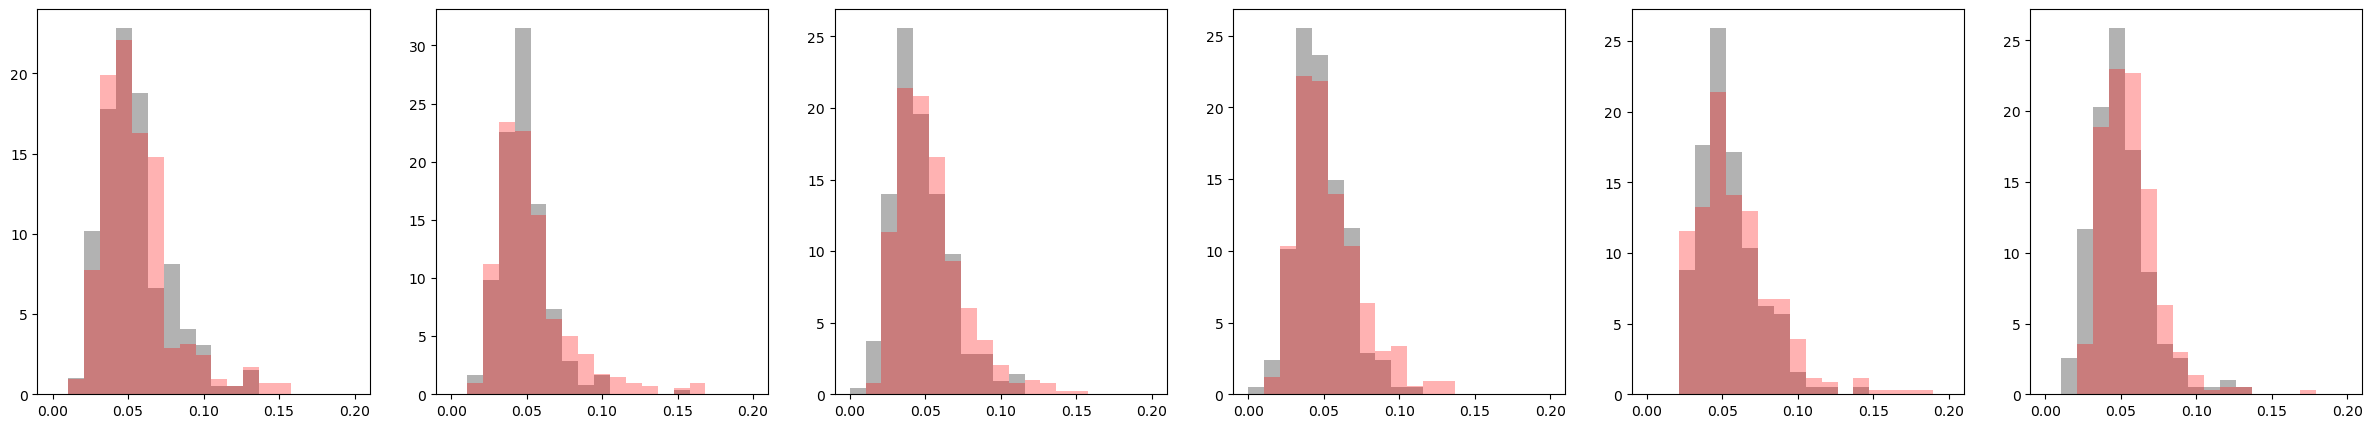

In [6]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.linspace(0,.2, num=20)
for day in range(6):
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                             df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)])
    print(t,p)

C:\Users\esay\AppData\Local\Temp\ipykernel_190292\525920552.py:8: RuntimeWarning: Mean of empty slice
  ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)
C:\Users\esay\AppData\Local\Temp\ipykernel_190292\525920552.py:15: RuntimeWarning: Mean of empty slice
  ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)


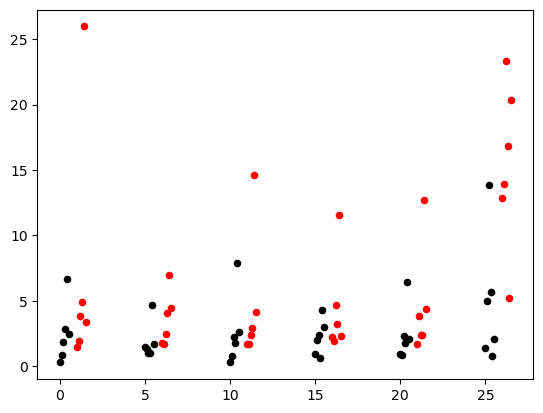

In [7]:
fig, ax = plt.subplots()

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['formation_lap'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['formation_lap'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)
    

In [17]:
lmm_res = MixedLM(df_shifts['field_var'], df_shifts[['ko', 'dz', 'ko_x_dz','nov', 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var 
No. Observations: 6339    Method:             REML      
No. Groups:       6       Scale:              0.0005    
Min. group size:  527     Log-Likelihood:     14810.1641
Max. group size:  1790    Converged:          Yes       
Mean group size:  1056.5                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.004    0.001  6.678 0.000  0.003  0.005
dz            -0.001    0.000 -1.367 0.172 -0.002  0.000
ko_x_dz       -0.000    0.001 -0.480 0.631 -0.001  0.001
nov            0.009    0.001 15.597 0.000  0.008  0.010
intercept      0.051    0.002 31.797 0.000  0.048  0.054
Group Var      0.000    0.000                           



C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Index(['mouse', 'm', 'day', 'dz', 'ko', 'nov', 'nov_x_dz', 'ko_x_dz',
       'ko_x_nov', 'ko_x_nov_x_dz', 'shifts', 'width', 'formation_lap',
       'init_speed', 'init_speed_x_ko', 'speed', 'ko_x_speed', 'field_var',
       'intercept'],
      dtype='object')
             names  coef    se     T  pval   r2  adj_r2  CI[2.5%]  CI[97.5%]
0        Intercept -0.26  0.10 -2.52  0.01  0.0     0.0     -0.46      -0.06
1  init_speed_x_ko  0.59  0.66  0.90  0.37  0.0     0.0     -0.70       1.89
2       init_speed -1.45  0.99 -1.47  0.14  0.0     0.0     -3.39       0.48
(306, 19) -0.056117488964147824 0.3278721969152525
(608, 19) -0.030859920627566095 0.4475246219271167


Text(0, 0.5, 'COM shift')

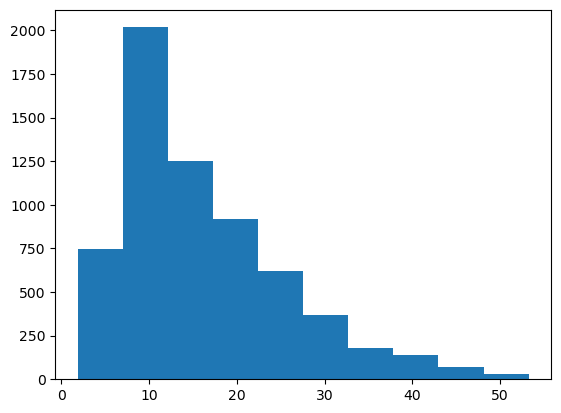

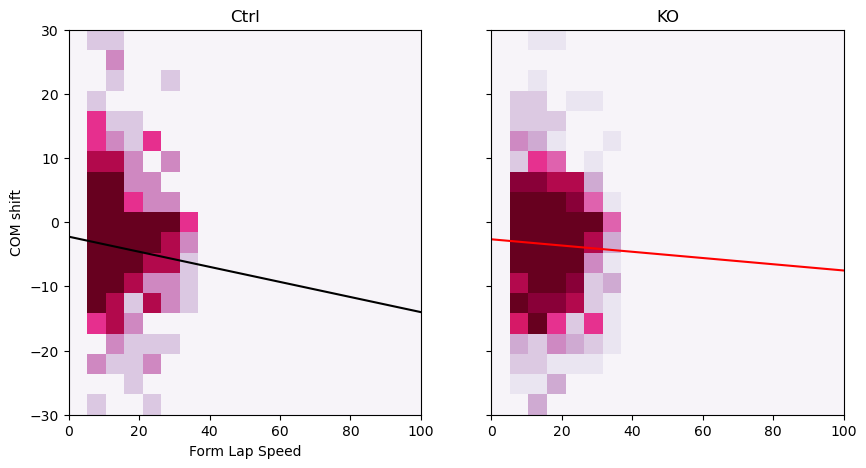

In [18]:
fig, ax = plt.subplots()


df_ = df_shifts[(df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
print(df_.columns)
res = linear_regression(df_[ ['init_speed_x_ko','init_speed']], df_['shifts'])
print(res.round(2))

ax.hist(10*15.46*df_shifts['init_speed'])

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05) ]
ax[0].hist2d(10*15.46*ctrl_df['init_speed'], 10*ctrl_df['shifts'], bins=(np.linspace(0,100,num=20),np.linspace(-30,30,num=20)),density=True,vmax=.001, cmap = 'PuRd') #, color='black')

res = sp.stats.linregress(10*15.46*ctrl_df['init_speed'],10*ctrl_df['shifts'])
x = np.linspace(0,100)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(10*15.46*ctrl_df['init_speed'],10*ctrl_df['shifts'])
# r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['shifts'])
print(ctrl_df.shape,r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
ax[1].hist2d(10*15.46*ko_df['init_speed'],10*ko_df['shifts'], bins=(np.linspace(0,100,num=20),np.linspace(-30,30,num=20)), density=True, vmax=.001,cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(10*15.46*ko_df['init_speed'],10*ko_df['shifts'])
# r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['shifts'])

res = sp.stats.linregress(10*15.46*ko_df['init_speed'], 10*ko_df['shifts'])
x = np.linspace(0,100)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(ko_df.shape,r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('COM shift')
# fig.savefig(os.path.join(figdir,"initspeed_vs_shifts_day0.pdf"))

In [43]:
df_shifts['ko']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6334    1.0
6335    1.0
6336    1.0
6337    1.0
6338    1.0
Name: ko, Length: 6339, dtype: float64

In [108]:
10*15.46*ctrl_df['init_speed']

0       9.454451
1      16.714595
2       8.303950
3       7.887848
4       7.794311
         ...    
340     9.711148
341     9.766328
342    14.993473
343    21.190069
344    10.054866
Name: init_speed, Length: 306, dtype: float64

4.062887391105658 6.818891645282268
0.05869593707500732 0.30609985926345556
18.245855679564634 4.300320667940863
0.2704170368271887 1.1946085870491227e-11


Text(0, 0.5, 'width')

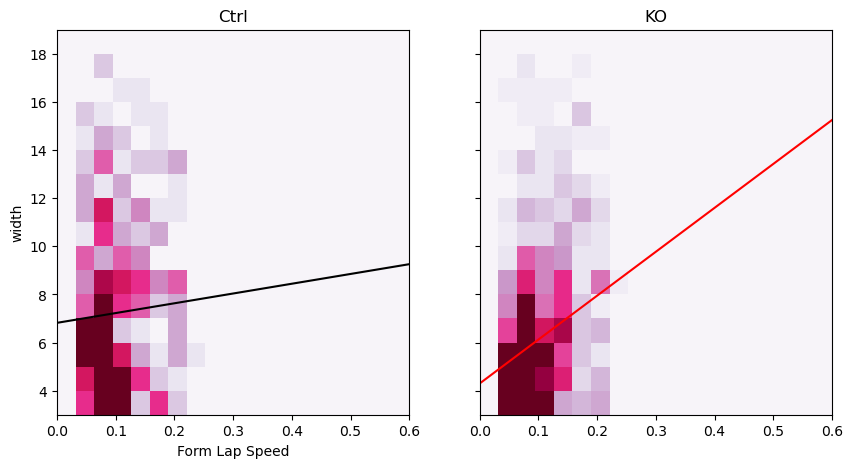

In [19]:
ctrl_df = []
ko_df = []
fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
h, xedges, yedges, _ = ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)),density=True, vmax = 1, cmap = 'PuRd')#, color='black')
# print(np.isnan(h).sum())
# print(xedges, yedges)

res = sp.stats.linregress(ctrl_df['init_speed'],ctrl_df['width'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['init_speed'],ctrl_df['width'])
r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['width'])
print(res.slope, res.intercept)

print(r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0)& (df_shifts['init_speed']>0.05)]
ax[1].hist2d(ko_df['init_speed'],ko_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['init_speed'],ko_df['width'])
r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['width'])

res = sp.stats.linregress(ko_df['init_speed'], ko_df['width'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(res.slope, res.intercept)
print(r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('width')
# fig.savefig(os.path.join(figdir,"initspeed_vs_width.pdf"))

C:\Users\esay\AppData\Local\Temp\ipykernel_190292\1578238712.py:28: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  res = sp.stats.linregress(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
C:\Users\esay\AppData\Local\Temp\ipykernel_190292\1578238712.py:33: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  r, p = sp.stats.spearmanr(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])


Ctrl: slope: 1.2684704756532745 intercept: 45.135234724007745
Spearman r: 0.3032704881993116 p: 4.749757004490814e-44


C:\Users\esay\AppData\Local\Temp\ipykernel_190292\1578238712.py:55: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  res = sp.stats.linregress(ko_df['init_speed_cm_s'], ko_df['width_cm'])
C:\Users\esay\AppData\Local\Temp\ipykernel_190292\1578238712.py:60: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  r, p = sp.stats.spearmanr(ko_df['init_speed_cm_s'], ko_df['width_cm'])


KO: slope: 1.4111259429297867 intercept: 33.468780224664044
Spearman r: 0.4268094963805064 p: 3.505355494488426e-168


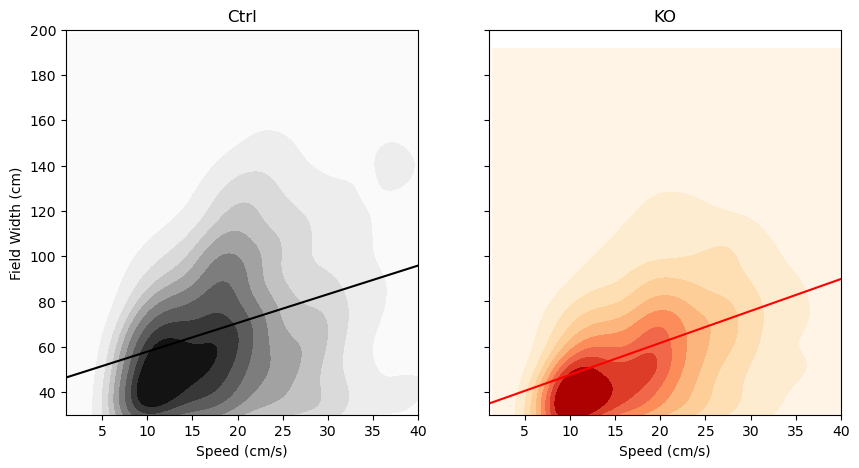

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp

fig, ax = plt.subplots(1, 2, figsize=[10, 5], sharey=True, sharex=True)

# Convert units: speed in cm/s (init_speed * 15.46 * 10), width in cm (width * 10)
ctrl_df = df_shifts[(df_shifts['ko'] == 0) & (df_shifts['speed'] > 0.05)].copy() # & (df_shifts['day'] == 0)
ctrl_df['init_speed_cm_s'] = ctrl_df['speed'] * 15.46 * 10
# ctrl_df['init_speed_cm_s'] = ctrl_df['init_speed'] * 15.46 * 10
ctrl_df['width_cm'] = ctrl_df['width'] * 10
# ctrl_df['shift_cm'] = ctrl_df['width'] * 10

# Seaborn KDE contour
sns.kdeplot(
    data=ctrl_df,
    x='init_speed_cm_s',
    y='width_cm',
    ax=ax[0],
    cmap='Greys',
    fill=True,
    levels=10,
    thresh=0,
)

# Regression line
res = sp.stats.linregress(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
x = np.linspace(0, 45)
ax[0].plot(x, res.slope * x + res.intercept, color='black')

# Correlation
r, p = sp.stats.spearmanr(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
print('Ctrl:', 'slope:', res.slope, 'intercept:', res.intercept)
print('Spearman r:', r, 'p:', p)

# KO group
ko_df = df_shifts[(df_shifts['ko'] == 1)  & (df_shifts['speed'] > 0.05)].copy() #& (df_shifts['day'] == 0)
ko_df['init_speed_cm_s'] = ko_df['speed'] * 15.46 * 10
# ko_df['init_speed_cm_s'] = ko_df['init_speed'] * 15.46 * 10
ko_df['width_cm'] = ko_df['width'] * 10

sns.kdeplot(
    data=ko_df,
    x='init_speed_cm_s',
    y='width_cm',
    ax=ax[1],
    cmap='OrRd',
    fill=True,
    levels=10,
    thresh=0,
)

# Regression line
res = sp.stats.linregress(ko_df['init_speed_cm_s'], ko_df['width_cm'])
x = np.linspace(0, 45)
ax[1].plot(x, res.slope * x + res.intercept, color='red')

# Correlation
r, p = sp.stats.spearmanr(ko_df['init_speed_cm_s'], ko_df['width_cm'])
print('KO:', 'slope:', res.slope, 'intercept:', res.intercept)
print('Spearman r:', r, 'p:', p)

# Labels
ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Speed (cm/s)')
ax[1].set_xlabel('Speed (cm/s)')
ax[0].set_ylabel('Field Width (cm)')

# Optional: set same axis limits for comparison
ax[0].set_xlim(1, 40)
ax[0].set_ylim(30, 200)

# Optional save
figdir = 'C:/Users/esay/data/Stx3/YMazeResults/neural'
fig.savefig(os.path.join(figdir,"initspeed_vs_width_kde.pdf"))


(array([833., 700., 793., 586., 401., 216., 103.,  76.,  70.,  24.]),
 array([ 7.73377401, 11.91012056, 16.08646712, 20.26281368, 24.43916024,
        28.6155068 , 32.79185336, 36.96819992, 41.14454647, 45.32089303,
        49.49723959]),
 <BarContainer object of 10 artists>)

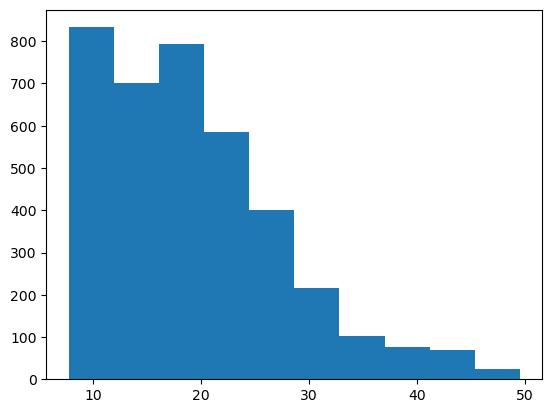

In [10]:
plt.hist(ko_df['init_speed_cm_s'])

In [47]:
# this z scores the original values
# speed_z = sp.stats.zscore(df_shifts['init_speed']._values)
# df_shifts['init_speed_z'] = speed_z
# df_shifts['init_speed_x_ko'] = speed_z*df_shifts['ko']._values

speed_z = sp.stats.zscore(df_shifts['speed']._values)
df_shifts['speed_z'] = speed_z
df_shifts['ko_x_speed'] = speed_z*df_shifts['ko']._values
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 
                                                 # 'dz', 
                                                 # 'ko_x_dz',
                                                 # 'init_speed_z', 
                                                 # 'init_speed_x_ko',
                                                 'speed_z',
                                                 'ko_x_speed',
                                                 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



C:\Users\esay\AppData\Local\Temp\ipykernel_175616\2468833420.py:6: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  speed_z = sp.stats.zscore(df_shifts['speed']._values)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: width      
No. Observations: 6339    Method:             REML       
No. Groups:       6       Scale:              7.2235     
Min. group size:  527     Log-Likelihood:     -15276.5890
Max. group size:  1790    Converged:          Yes        
Mean group size:  1056.5                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko            -0.943    0.072 -13.083 0.000 -1.084 -0.801
speed_z        1.321    0.066  20.165 0.000  1.192  1.449
ko_x_speed     0.069    0.071   0.980 0.327 -0.069  0.208
intercept      6.824    0.208  32.879 0.000  6.417  7.230
Group Var      0.237    0.059                            



### permutation test

In [50]:
import statsmodels.formula.api as smf

In [67]:
# model = smf.mixedlm("width ~ ko + speed",df_shifts, groups=df_shifts['mouse'])
model =  MixedLM(df_shifts['width'], df_shifts[['ko', 
                                                 'speed_z',
                                                 # 'ko_x_speed',
                                                 'intercept']], df_shifts['mouse'])
real_fit = model.fit()
real_coef = real_fit.params['ko']
print("real KO coeff:", real_coef)

real KO coeff: -0.9408677673758641


In [55]:
n_perms = 1000
perm_coef = []

for i in range(n_perms):
    df_perm = df_shifts.copy()

    for mouse in df_perm['mouse'].unique():
        mask = df_perm['mouse'] == mouse
        shuff = np.random.permutation(df_perm.loc[mask, 'ko'].values)
        df_perm.loc[mask, 'ko'] = shuff

    # try:
    perm_fit = smf.mixedlm("width ~ ko + speed",df_perm, groups=df_perm['mouse']).fit()
    perm_coef.append(perm_fit.params['ko'])
    # except:
    #     continue

perm_coef = np.array(perm_coef)

        

In [64]:
upper = np.percentile(np.abs(perm_coef),95)

if np.abs(real_coef) > upper:
    print('Real greater than 95th percentile of shuffles')
else:
    print('sad ur data sucks')
print(f"Real coef: {real_coef:.3f},95th percentile of shuff: {upper:.3f}")

Real greater than 95th percentile of shuffles
Real coef: -0.941,95th percentile of shuff: 0.144


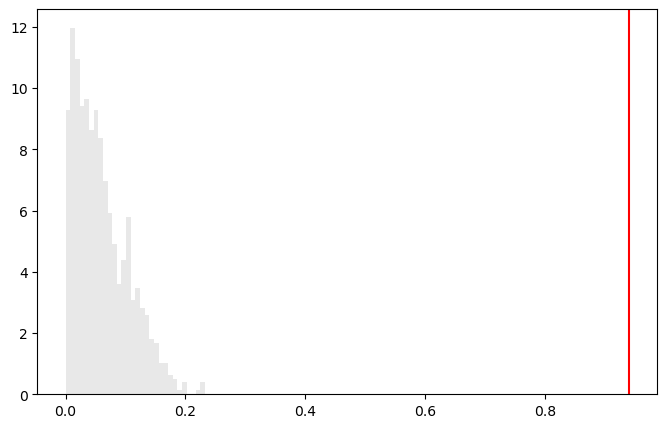

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(np.abs(perm_coef), bins=30, color='lightgray', density=True, alpha=0.5)
ax.axvline(np.abs(real_coef), color='red')


### continued debugging shit

C:\Users\esay\AppData\Local\Temp\ipykernel_175616\3468830288.py:9: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],


-7.9862761236851645 3.702478465756809e-15
-6.021163546862647 2.331066956570299e-09
-3.0561851250349945 0.002297994090655814
-3.540086365688966 0.0004185647713012765
-7.000412460168991 4.5900657581164606e-12
-7.768148711577389 1.8513113553553958e-14


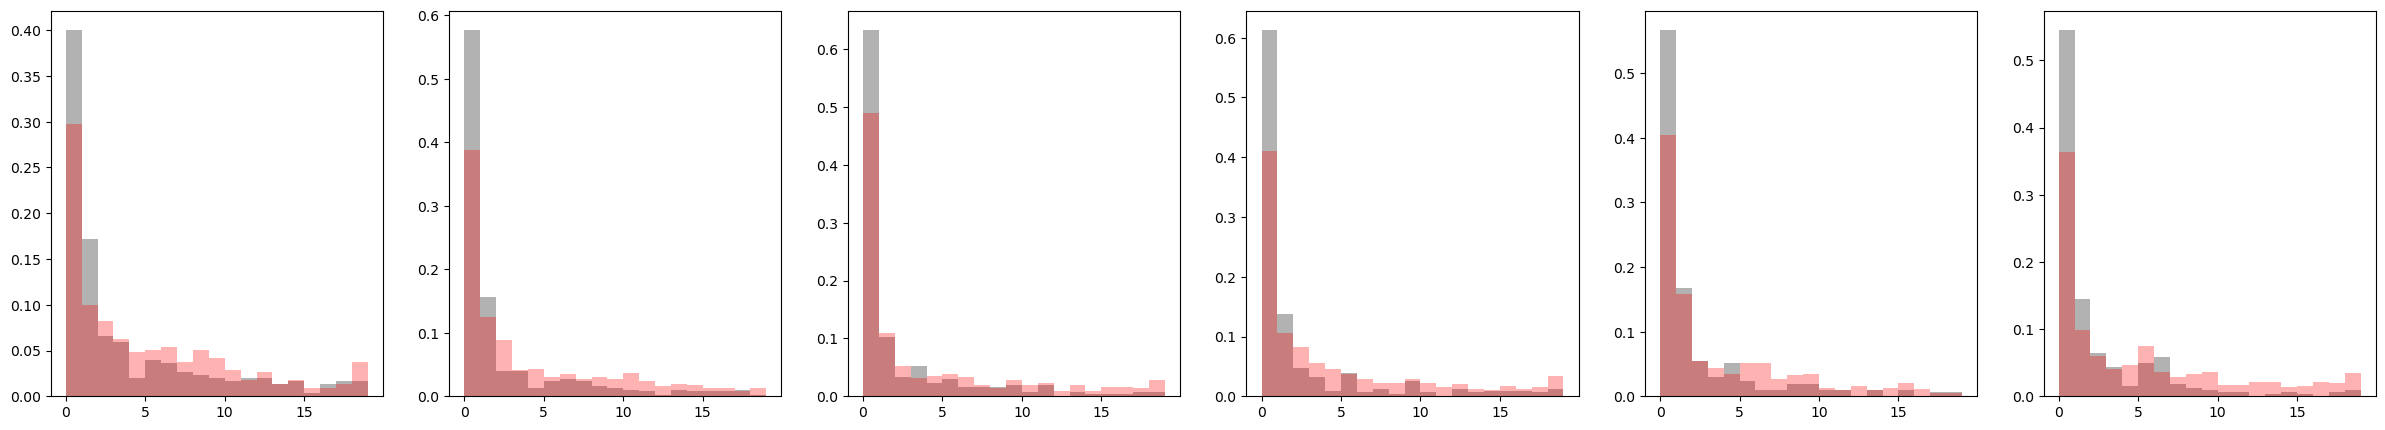

In [23]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.arange(20)
for day in range(6):
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) ],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],
                             df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)])
    print(t,p)

In [24]:
lmm_res = MixedLM(df_shifts['formation_lap'], df_shifts[['ko', 'dz', 'ko_x_dz']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: formation_lap
No. Observations: 6339    Method:             REML         
No. Groups:       6       Scale:              409.9926     
Min. group size:  527     Log-Likelihood:     -28075.9386  
Max. group size:  1790    Converged:          Yes          
Mean group size:  1056.5                                   
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
ko            8.163     0.545  14.981  0.000   7.095   9.231
dz           -0.603     0.433  -1.391  0.164  -1.452   0.247
ko_x_dz      -0.508     0.535  -0.950  0.342  -1.556   0.540
Group Var    57.440     1.692                               



In [25]:
aov = mixed_anova(data = df_shifts[df_shifts['nov'] == 0], dv = 'formation_lap', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source           SS  DF1  DF2           MS         F     p-unc  \
0           ko  1847.021983    1   10  1847.021983  5.077225  0.047913   
1          day   911.233138    5   50   182.246628  3.919854  0.004474   
2  Interaction   247.193551    5   50    49.438710  1.063353  0.391818   

        np2       eps  
0  0.336748       NaN  
1  0.281602  0.601106  
2  0.096115       NaN  


In [31]:
df_day1

,mouse,m,day,dz,ko,nov,nov_x_dz,ko_x_dz,ko_x_nov,ko_x_nov_x_dz,...,width,formation_lap,init_speed,init_speed_x_ko,speed,ko_x_speed,field_var,intercept,init_speed_z,speed_z
0,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,...,5.0,0.0,0.061154,-0.000000,0.062205,-0.000000,0.060945,1.0,-0.799812,-1.217271
1,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,...,8.0,0.0,0.108115,0.000000,0.102054,-0.000000,0.039354,1.0,0.229840,-0.279361
2,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,...,4.0,0.0,0.053712,-0.000000,0.063017,-0.000000,0.056113,1.0,-0.962979,-1.198166
3,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,...,6.0,0.0,0.051021,-0.000000,0.061777,-0.000000,0.044831,1.0,-1.021991,-1.227356
4,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,...,3.0,0.0,0.050416,-0.000000,0.058652,-0.000000,0.080746,1.0,-1.035257,-1.300897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,SparseKO_13,11.0,0.0,-1.46385,1.0,0.0,0.00000,-1.46385,0.0,0.0,...,7.0,0.0,0.062640,-0.767238,0.108821,-0.120088,0.021303,1.0,-0.767238,-0.120088
1027,SparseKO_13,11.0,0.0,-1.46385,1.0,0.0,0.00000,-1.46385,0.0,0.0,...,11.0,45.0,0.137336,0.870530,0.183100,1.628207,0.037006,1.0,0.870530,1.628207
1028,SparseKO_13,11.0,0.0,-1.46385,1.0,0.0,0.00000,-1.46385,0.0,0.0,...,5.0,2.0,0.060348,-0.817485,0.156386,0.999446,0.073549,1.0,-0.817485,0.999446
1029,SparseKO_13,11.0,0.0,-1.46385,1.0,0.0,0.00000,-1.46385,0.0,0.0,...,3.0,0.0,0.076238,-0.469099,0.123105,0.216101,0.099718,1.0,-0.469099,0.216101


In [38]:
# this z scores the original values
df_day1 = df_shifts[df_shifts['day'] ==0].copy()

speed_z = sp.stats.zscore(df_day1['init_speed']._values)
# df_shifts['init_speed_z'] = []
df_day1['init_speed_z'] = speed_z
df_day1['init_speed_x_ko'] = speed_z*df_day1['ko']._values

speed_z = sp.stats.zscore(df_day1['speed']._values)
# df_shifts['speed_z'] = []
df_day1['speed_z'] = speed_z
df_day1['ko_x_speed'] = speed_z*df_day1['ko']._values
lmm_res = MixedLM(df_day1['shifts'], df_day1[['ko', 
                                                 # 'dz', 
                                                 # 'ko_x_dz',
                                                 'init_speed_z', 
                                                 'init_speed_x_ko',
                                                 # 'speed_z',
                                                 # 'ko_x_speed',
                                                 'intercept']], df_day1['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: shifts    
No. Observations:   1031    Method:             REML      
No. Groups:         6       Scale:              1.3465    
Min. group size:    102     Log-Likelihood:     -1622.4142
Max. group size:    233     Converged:          Yes       
Mean group size:    171.8                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko               0.086    0.077  1.116 0.264 -0.065  0.236
init_speed_z    -0.063    0.062 -1.023 0.306 -0.184  0.058
init_speed_x_ko  0.021    0.076  0.276 0.782 -0.128  0.170
intercept       -0.419    0.063 -6.691 0.000 -0.541 -0.296
Group Var        0.000    0.007                           



C:\Users\esay\AppData\Local\Temp\ipykernel_175616\2295797721.py:4: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  speed_z = sp.stats.zscore(df_day1['init_speed']._values)
C:\Users\esay\AppData\Local\Temp\ipykernel_175616\2295797721.py:9: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  speed_z = sp.stats.zscore(df_day1['speed']._values)
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(14, 14)
(14, 1)
(14, 14)
(14, 1)


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\3362481206.py:47: RuntimeWarning: invalid value encountered in divide
  COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\3362481206.py:48: RuntimeWarning: invalid value encountered in divide
  COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])


(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)


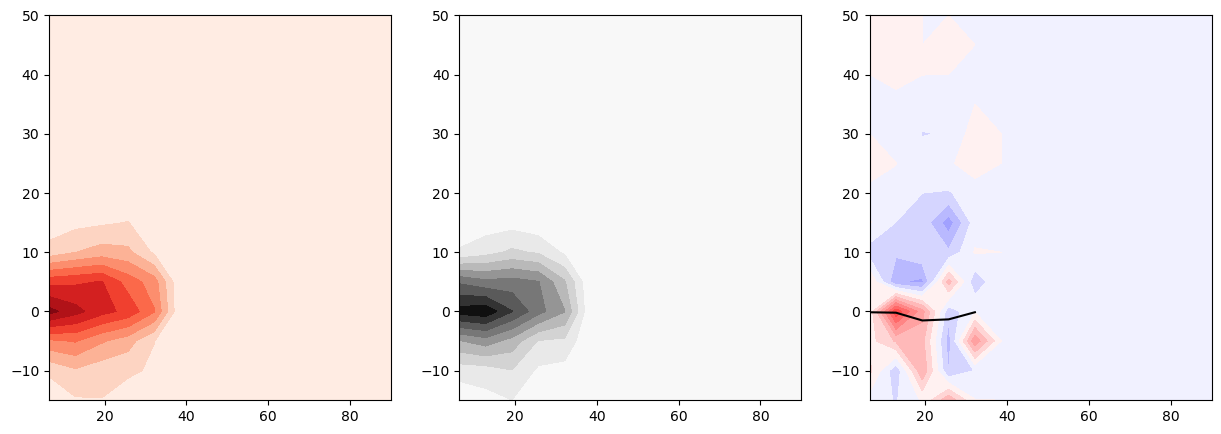

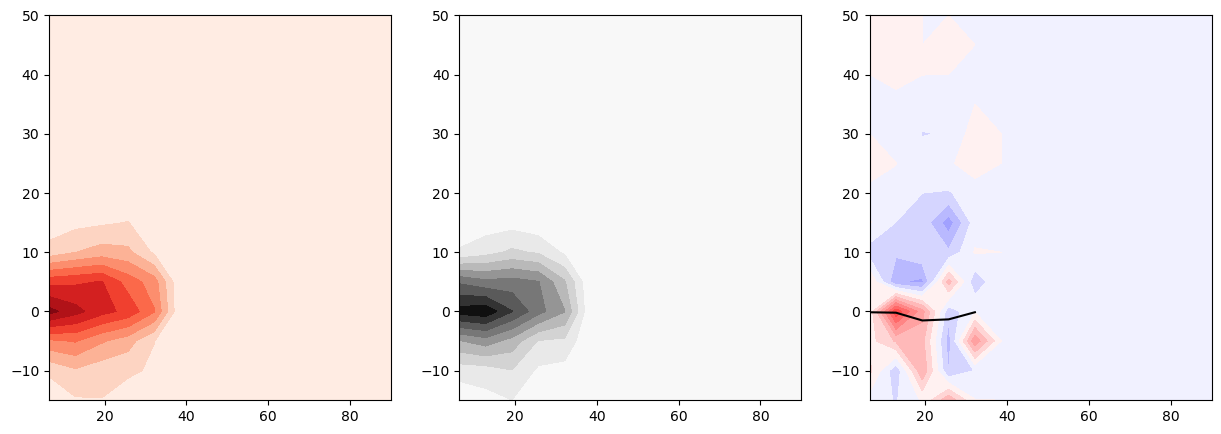

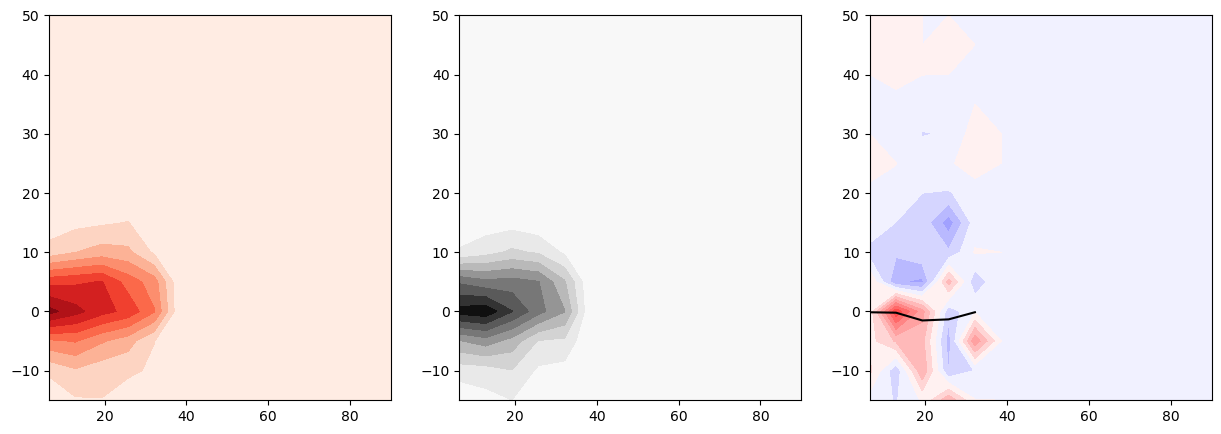

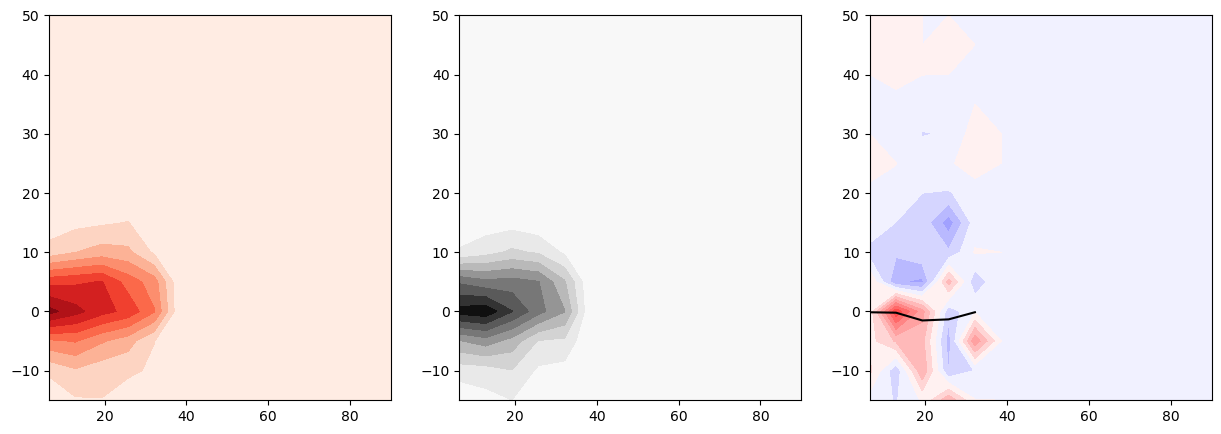

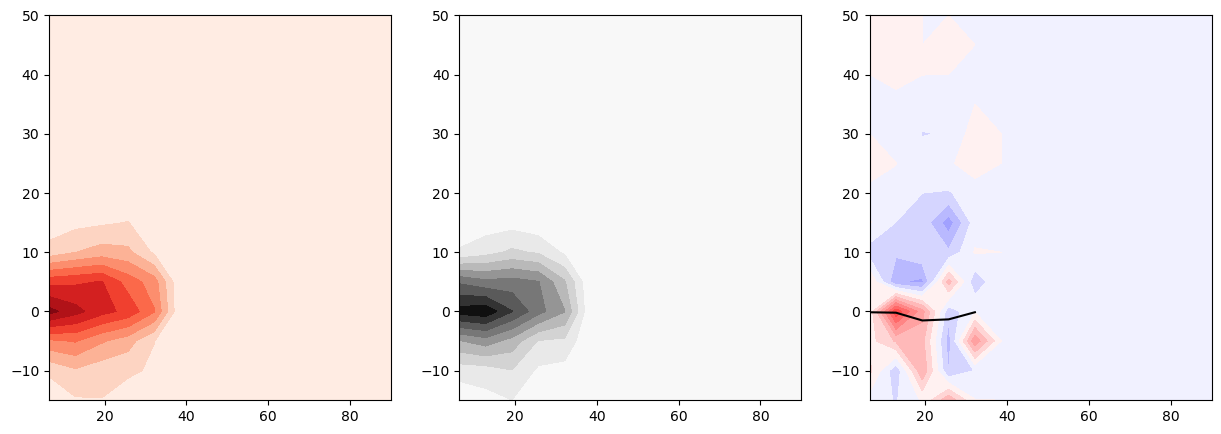

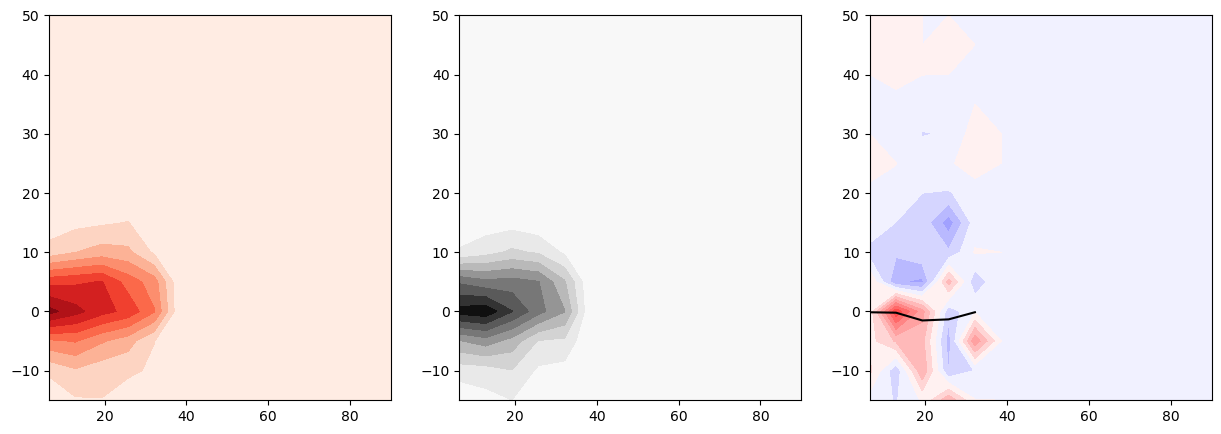

In [71]:

day = 0
ttype= 'nov'

for day in range(6):
    shift, speed = [], []
    df_ctrl = df_shifts[df_shifts['ko']==0]
    shift = 10*df_ctrl['shifts']
    speed =100*df_ctrl['speed']

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    fig, ax = plt.subplots(1,3,figsize=[15,5]) #,sharey=True, sharex=True, )
    speed_bins = np.linspace(0, 90, num=15)
    shift_bins = np.linspace(-20,50, num=15)
    # shift_bins = np.linspace(0,150, num=15)
    X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
    

    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ko =np.copy(H)
    H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
    print(H.shape)
    
    ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
    

    shift, speed = [], []
    df_ko = df_shifts[df_shifts['ko']==1]
    shift = 10*df_ko['shifts']
    speed = 100*df_ko['speed']



    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ctrl = np.copy(H)
    H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)
    
    ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')
    res = sp.stats.pearsonr(speed[mask],shift[mask])
    
    ax[2].contourf(X, Y, (H_ctrl-H_ko).T, 10, cmap='seismic', vmin=-.15, vmax=.15)
    diff = H_ctrl-H_ko
    COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
    COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])
    print(COM.shape)
    ax[2].plot(speed_bins[1:], COM, color='black')
    ax[2].plot(speed_bins[1:],0*speed_bins[1:], color='blue', zorder=-1)

# print(res)

In [78]:
import statsmodels.formula.api as smf

In [90]:
ddf = df_shifts[(df_shifts['nov']==ttype) * (df_shifts['day']==day)  * (100*df_shifts['speed']<80) * (df_shifts['speed']>0)] #* (df['fwhm']<300)
df_shifts

,mouse,m,day,dz,ko,nov,nov_x_dz,ko_x_dz,ko_x_nov,ko_x_nov_x_dz,shifts,width,formation_lap,init_speed,init_speed_x_ko,speed,ko_x_speed,field_var,intercept
0,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,-0.428209,5.0,0.0,0.061154,0.000000,0.062205,0.000000,0.060945,1.0
1,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,-0.937489,8.0,0.0,0.108115,0.000000,0.102054,0.000000,0.039354,1.0
2,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,-0.169050,4.0,0.0,0.053712,0.000000,0.063017,0.000000,0.056113,1.0
3,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,-0.220627,6.0,0.0,0.051021,0.000000,0.061777,0.000000,0.044831,1.0
4,SparseKO_02,0.0,0.0,-1.46385,0.0,1.0,-1.46385,0.00000,0.0,0.0,-0.604505,3.0,0.0,0.050416,0.000000,0.058652,0.000000,0.080746,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,SparseKO_13,11.0,5.0,1.46385,1.0,0.0,0.00000,1.46385,0.0,0.0,-0.650865,5.0,0.0,0.267905,0.258402,0.258402,0.258402,0.079591,1.0
6335,SparseKO_13,11.0,5.0,1.46385,1.0,0.0,0.00000,1.46385,0.0,0.0,-0.228230,8.0,1.0,0.210027,0.267895,0.267895,0.267895,0.089478,1.0
6336,SparseKO_13,11.0,5.0,1.46385,1.0,0.0,0.00000,1.46385,0.0,0.0,0.080306,3.0,0.0,0.215225,0.280994,0.280994,0.280994,0.082403,1.0
6337,SparseKO_13,11.0,5.0,1.46385,1.0,0.0,0.00000,1.46385,0.0,0.0,0.060745,8.0,49.0,0.258471,0.235467,0.235467,0.235467,0.118536,1.0


In [145]:
# sess = u.load_single_day('SparseKO_02', 0)
import joblib

In [148]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)

def make_masks(sess):
    trial_masks = {'left': None, 
                   'right': None, }
        # 'channel_0_left': None,
        #        'channel_0_right': None,
        #        'channel_1_left': None,
        #        'channel_1_right': None}
    left_mask = sess.trial_info['LR']==-1
    trial_masks['left'] = left_mask
    trial_masks['right'] = ~left_mask
    # trial_masks['channel_0_left'] = left_mask
    # trial_masks['channel_0_right'] = ~left_mask
    # trial_masks['channel_1_left'] = left_mask
    # trial_masks['channel_1_right'] = ~left_mask

    return trial_masks


In [ ]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
shuff_results = {}
# trial_means = {}
# field_info = {}

for mouse in sparse_mice:
    print(mouse)
    shuff_results[mouse] = {}
    # trial_means[mouse] = {}
    # field_info[mouse] = {}
    if mouse == 'SparseKO_12':
        days = 1
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):

        # set up output dicts
        shuff_results[mouse][day] = {}
        # trial_means[mouse][day] = {}
        # field_info[mouse][day] = {}

        # load sess file
        sess = u.load_single_day(mouse, day)

        # make LR masks
        trial_masks = make_masks(sess)

        # # make mux masks 
        # chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
        # chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F1 = sess.timeseries['channel_0_F_dff']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['left']], sess.trial_ends['channel_0'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F2 = sess.timeseries['channel_0_F_dff']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['right']], sess.trial_ends['channel_0'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F3 = sess.timeseries['channel_1_F_dff']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['left']], sess.trial_ends['channel_1'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F4 = sess.timeseries['channel_1_F_dff']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['right']],sess.trial_ends['channel_1'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # # caluculate trial means
        # temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['left'], : , :],axis=0),
        #        'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['right'], : , :],axis=0),
        #        'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['left'], : , :],axis=0),
        #        'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['right'], : , :],axis=0),
        #       }
        
        
        # # shuff_thresh = shuff_thresh[mouse][day]
        # temp_field_info = get_field_info(shuff_thresh, temp_trial_means)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results
        # trial_means[mouse][day] = temp_trial_means # save to trial_means
        # field_info[mouse][day] = temp_field_info #save to field info
        


In [206]:
shuff_results = pd.read_pickle("C:/Users/esay/data/Stx3/sparse_analyses/field_prop/place_field_shuff_results_dff.pkl")

In [208]:
chan = 'channel_0'
sess = u.load_single_day('SparseKO_02', 0)
sess.trial_ends[chan]

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


array([  665,  1197,  1591,  1987,  2319,  2634,  3162,  3902,  4510,
        5467,  6991,  7522,  8011,  8400,  8788,  9442,  9940, 11118,
       13734, 14358, 14917, 15399, 15985, 16427, 16908, 18481, 19056,
       19747, 20366, 20899, 21378, 21959, 22654, 23900, 24394, 25122,
       25592, 26629, 27181, 27667, 28170, 28613, 29875, 30218, 30593,
       30992, 31332, 31646, 32098, 32357, 32700, 33107, 33364, 33698,
       33994, 34352, 34686, 35029, 35397, 35774, 36153, 36517, 36905,
       38278, 38639, 38948], dtype=int64)

In [274]:
# this doesnt work lol
def get_field_info(mouse, day, ttype, chan):
    fkey = chan + '_F_dff'
    spkey = chan + '_speed'
    
    sess = u.load_single_day(mouse, day)
    if chan == 'channel_0':
        cond = 'cre'
        vr_data = sess.vr_data_chan0
    elif chan == 'channel_1':
        cond = 'ctrl'
        vr_data = sess.vr_data_chan1

        
    if ttype == 'fam':
        trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) * (sess.trial_info['block_number']==5)
        if sess.novel_arm == -1:
            arm = chan + '_right'
        elif sess.novel_arm == 1:
            arm = chan + '_left'
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm
        if sess.novel_arm == 1:
            arm = chan + '_right'
        elif sess.novel_arm == -1:
            arm = chan + '_left'
    else:
        pass

    # sess.add_pos_binned_trial_matrix('speed')
    speed = np.nanmean(np.nanmean(sess.trial_matrices[spkey][trial_mask,:]))
    trial_avg = np.nanmean(sess.trial_matrices[fkey][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][arm]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
            
            place_field = sess.trial_matrices[fkey][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices[spkey][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)
            thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fwhm = np.nan*np.zeros([len(field_info)])



        
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices[fkey][trial_mask,  l_edge:l_edge+r_edge, cell]
        
        # pos = np.arange(place_field.shape[1])[np.newaxis,:]
        # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
        # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        # maxact = []
        starts = sess.trial_starts[chan][trial_mask]
        stops = sess.trial_ends[chan][trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = vr_data['t'][start:stop]
            speed = sess.timeseries[spkey][0, start:stop]
            spks = np.copy(sess.timeseries[fkey][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) #& (speed>2)
            # print(mask)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                # com.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                # maxact.append(np.nan)
                
        com_mat[:len(com), c] = np.array(com)
        # maxact_mat[:len(maxact),c] = np.array(maxact)
        
#         _com = np.nanmean(com[1:])
        mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
        field_max = np.amax(mu_field)
        
        cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))
        
        mu_field = (mu_field - cell_min)/(field_max - cell_min)
        
        l = 0
        while mu_field[l]<.5:
            l += 1
        
        
        r = 1
        while mu_field[-r]<.5:
            r += 1
        r -= 1
            
        fwhm[c] = r_edge -l - r


    return field_info, com_mat, fs_mat, fwhm, speed #maxact_mat#, pd.DataFrame(df)



field_stats = {}
df = []
for mouse in (sparse_mice):
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):
            field_stats[mouse][day][ttype]={}
            
            # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
            field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype, chan = 'channel_1')
            # df.append(_df)
            field_stats[mouse][day][ttype]['field_info'] = field_info
            field_stats[mouse][day][ttype]['com'] = com_mat
            field_stats[mouse][day][ttype]['field_strength'] = fs_mat
            # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
            field_stats[mouse][day][ttype]['fwhm'] = fwhm
            field_stats[mouse][day][ttype]['speed'] = speed
            
# df = pd.DataFrame(df)

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session'

C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:33: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices[fkey][trial_mask, :, :],axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan'

C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:33: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices[fkey][trial_mask, :, :],axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:33: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices[fkey][trial_mask, :, :],axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:33: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices[fkey][trial_mask, :, :],axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1683394476.py:126: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices[fkey][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


In [278]:
speed

array([2.00258106e-01, 2.04199083e-01, 2.09532108e-01, 2.16731731e-01,
       2.25422349e-01, 2.34613519e-01, 2.43394188e-01, 2.51574515e-01,
       2.59444508e-01, 2.67033974e-01, 2.73741342e-01, 2.78711433e-01,
       2.81283819e-01, 2.81310586e-01, 2.78775426e-01, 2.74030117e-01,
       2.67950410e-01, 2.62029303e-01, 2.57791026e-01, 2.56251028e-01,
       2.57791026e-01, 2.62029303e-01, 2.67982034e-01, 2.74154185e-01,
       2.79216619e-01, 2.82568204e-01, 2.84367897e-01, 2.85025082e-01,
       2.84759049e-01, 2.83445253e-01, 2.80415674e-01, 2.74818324e-01,
       2.65874738e-01, 2.53454716e-01, 2.38264882e-01, 2.21982364e-01,
       2.07084291e-01, 1.95810836e-01, 1.88994981e-01, 1.85248079e-01,
       1.82156628e-01, 1.77809982e-01, 1.71725057e-01, 1.64600582e-01,
       1.57501931e-01, 1.51519073e-01, 1.47194272e-01, 1.44437878e-01,
       1.42460201e-01, 1.40342778e-01, 1.37453167e-01, 1.33533329e-01,
       1.28790021e-01, 1.23221243e-01, 1.15716058e-01, 1.04446273e-01,
      

C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1007937058.py:40: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1007937058.py:40: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1007937058.py:73: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_169144\1007937058.py:73: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See docume

-0.13458986239964787 0.892952907178547
0.21240160466154254 0.8318156302721214
0.3772766213543357 0.7060206079089035
-1.4154081257284659 0.15715277805784506
1.2738712615284429 0.20288276472366285
0.6919214840185856 0.48907874217782255
-0.3325719242384335 0.7394958452149615
1.6385621792599898 0.10147180316471147
-0.9657716181501368 0.33430396731176537
2.025996729642206 0.04293383026489746
-0.5904977147629306 0.5549446831979892
-1.3578753013921776 0.17473816474771692


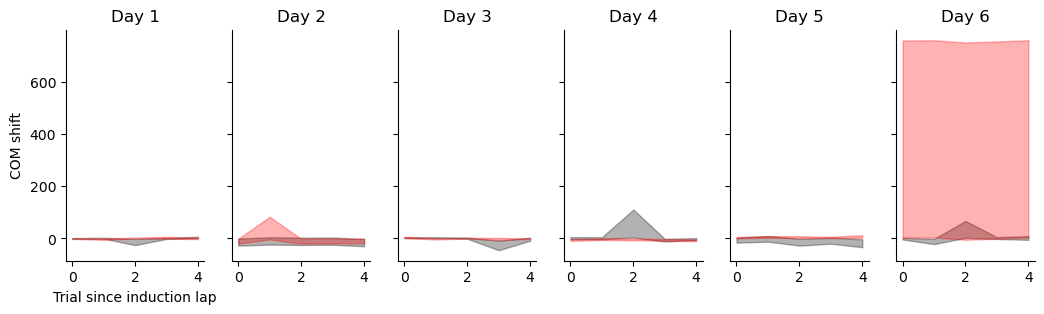

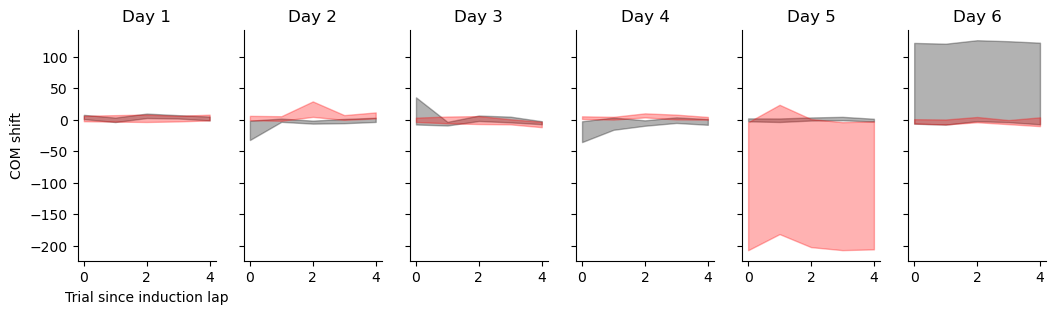

In [276]:

max_trial=140 #5
plot_max = 5
# ttype = 'nov'
df = {'mouse': [], 'cond':[], 'day':[], 'shift':[], 'nov':[]}
for ttype in ('fam', 'nov'):
    fig, ax = plt.subplots(1,6, sharey=True, figsize=[12.5,3])
    for day in range(6):
        # com = []
        # ctrl_com = np.nan*np.zeros((len(ctrl_mice),max_trial))
        ctrl_com = []

        for m, mouse in enumerate(sparse_mice):
        
            field_info = np.array(channel_1_field_stats[mouse][day][ttype]['field_info'])
            _com = channel_1_field_stats[mouse][day][ttype]['com']
            
            mask = field_info[:,1]>0
            
            _com = (_com[:, mask] - np.nanmean(_com[1:, mask], axis=0,keepdims=True))
            
            for c in range(_com.shape[1]):
                _ctrl_com = np.nan*np.zeros((max_trial,))
                _ctrl_com[:_com.shape[0]] = 10*_com[:,c]
                ctrl_com.append(_ctrl_com)
            
            
            
            # ctrl_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)
            

            df['mouse'].append(mouse)
            df['cond'].append('ctrl')
            df['day'].append(day)
            
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)

            
        ctrl_com = np.array(ctrl_com)
        mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')           
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='black', alpha=.3) 

        # com = []
        # ko_com = np.nan*np.zeros((len(ko_mice), max_trial))
        ko_com=[]
        for m, mouse in enumerate(sparse_mice):
            _com = channel_0_field_stats[mouse][day][ttype]['com']
            
            field_info = np.array(channel_0_field_stats[mouse][day][ttype]['field_info']) 
            mask = field_info[:,1]>0
            
            _com = (_com[:, mask] - np.nanmean(_com[1:,:][:,mask], axis=0,keepdims=True))
            
            for c in range(_com.shape[1]):
                _ko_com = np.nan*np.zeros((max_trial,))
                _ko_com[:_com.shape[0]] = 10*_com[:,c]
                ko_com.append(_ko_com)
            
            # ko_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)

            df['mouse'].append(mouse)
            df['cond'].append('cre')
            df['day'].append(day)
            
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)


            


        ko_com = np.array(ko_com)
        mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')           
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='red', alpha=.3) 


        ax[day].spines['top'].set_visible(False)
        ax[day].spines['right'].set_visible(False)
        ax[day].set_title(f'Day {day+1}')


        t, p = sp.stats.ttest_ind(ko_com[:, 0], ctrl_com[:,0])
        print(t,p)

        ax[0].set_ylabel('COM shift')
        ax[0].set_xlabel('Trial since induction lap')
        

# fig.savefig(os.path.join(figdir, f"single_field_COM_shift_maxtrial_{plot_max}_ttype_{ttype}.pdf"))
df = pd.DataFrame(df)

In [12]:
_['relative_com']

array([-4.88634659,  1.12633784,  0.87240899,  1.00682548,  0.76864151])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_relative_com(data_dict, color='gray', label=None):
    """
    data_dict: output of field_shifts()
    color: line/shade color
    label: legend label
    """
    rel_com = data_dict['relative_com']  # shape (n_fields, 5)
    
    # Insert formation lap COM at position 0
    # Formation lap is always relative_com = 0 by definition
    rel_com_with_formation = np.hstack([np.zeros((rel_com.shape[0], 1)), rel_com])
    
    # Compute mean and SEM across fields
    mean_vals = np.nanmean(rel_com_with_formation, axis=0)
    sem_vals = stats.sem(rel_com_with_formation, axis=0, nan_policy='omit')
    
    x = np.arange(rel_com_with_formation.shape[1])  # 0 = formation lap
    plt.plot(x, mean_vals, color=color, label=label)
    plt.fill_between(x, mean_vals - sem_vals, mean_vals + sem_vals, 
                     color=color, alpha=0.3)

# Example usage
plt.figure(figsize=(3,4))
plot_relative_com(_, color='gray', label='WT')
# plot_relative_com(day1_ko_dict, color='red', label='KO')

plt.xticks(range(6), labels=[0,1,2,3,4,5])
plt.xlabel('Trial Post Formation Lap')
plt.ylabel('Relative COM (cm)')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

<Figure size 300x400 with 0 Axes>

### try mari's method

In [178]:
sess = u.load_single_day('SparseKO_06', 0)
sess.vr_data_chan0

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


,time,trialnum,t,posx,posz,dz,lick,reward,tstart,teleport,scanning,manrewards,LR,cmd,pos,speed,lick rate
0,0.000,-1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-500.0,0.000000,0.000000
1,0.064,-1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-500.0,0.000000,0.000000
2,0.128,-1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-500.0,0.000000,0.000000
3,0.192,-1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-500.0,0.000000,0.000000
4,0.256,-1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-500.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38083,2437.312,131.0,41.260315,94.642688,0.0,0.066401,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-500.0,2.075036,0.037954
38084,2437.376,131.0,41.450903,96.264902,0.0,0.077325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-500.0,2.416415,0.009147
38085,2437.440,131.0,41.666102,98.083818,0.0,0.075495,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-500.0,2.359218,0.000836
38086,2437.504,131.0,41.876562,99.848309,0.0,0.059552,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-500.0,1.861012,0.000000


In [179]:
def find_first_n(a, n, window=5):
    
    ## James Priestley method of finding a formation lap
    ## from: https://github.com/james-priestley/ca1_novelty_analysis/blob/a04e357905cacc1efd75ec96ffcb6e293bb71ab9/platz/platz/util.py#L59

    for index, item in enumerate(a):
        if item:
            count = np.sum(a[index:index + window] > 0)
            if count >= n:
                return index

In [ ]:
def find_sig_active_fields(sess,
                           key = 'channel_0_spks_smooth',
                           trial_dict,
                           cell_ids=None,
                           smooth_for_field=True,
                           n_std=2,
                           n_trials_thr=6,
                           field_thr=0.2,
                           sigma=1,
                           speed_thr=2,
                           n_shuf=100):
    ''' 
    Find significantly active fields per cell

    This function does most of the heavy lifting for this notebook
    '''

    # Get the trial-by-trial activity, at speeds > speed_thr
    tm = TwoPUtils.spatial_analyses.trial_matrix(sess.timeseries[key].T,
                                                 sess.vr_data_chan0['pos']._values,
                                                 sess.trial_start_inds,
                                                 sess.teleport_inds,
                                                 bin_size=10,
                                                 min_pos=0,
                                                 max_pos=450,
                                                 speed_thr=speed_thr,
                                                 speed=sess.vr_data['speed']._values
                                                 )

    field_dict_thresh = {'set 0': [],
                         'set 1': []
                         }

    # field detection before the switch
    trial_set0_mask = trial_dict['trial_set0']
    field_dict_thresh['set 0'] = spatial.field_from_thresh(tm[0][trial_set0_mask, :, :],
                                                           tm[-1],
                                                           cells=cell_ids,
                                                           prctile=field_thr,
                                                           smooth=smooth_for_field,
                                                           sigma=sigma)

    trial_set1_mask = np.zeros(trial_dict['trial_set1'].shape).astype(bool)
    trial_set1_mask[-30:] = True

    # field detection in the last 30 trials after the switch
    field_dict_thresh['set 1'] = spatial.field_from_thresh(tm[0][trial_set1_mask, :, :],
                                                           tm[-1],
                                                           cells=cell_ids,
                                                           prctile=field_thr,
                                                           smooth=smooth_for_field,
                                                           sigma=sigma)

    # field detection using all post-switch trials (typically wider boundaries)
    full_set1_field = spatial.field_from_thresh(tm[0][trial_dict['trial_set1'], :, :],
                                                tm[-1],
                                                cells=cell_ids,
                                                prctile=field_thr,
                                                smooth=smooth_for_field,
                                                sigma=sigma)

    rzone_pos, _ = behav.get_reward_zones(sess)
    rzone = {'0': rzone_pos[0][0],
             '1': rzone_pos[-1][0]
             }

    trial_mat = np.copy(tm[0])
    if smooth_for_field:
        trial_mat = ut.nansmooth(trial_mat, 1, axis=1)

    pos = tm[-1]

    # Initialize
    keep_field_dict = copy.deepcopy(field_dict_thresh)
    keep_field_dict['set 0']['speed'] = sess.trial_matrices['speed'][0][trial_set0_mask, :]
    keep_field_dict['set 1']['speed'] = sess.trial_matrices['speed'][0][trial_set1_mask, :]
    # Iterate through trial sets
    for s in ['0', '1']:
        keep_field_dict[s]['active_in_field'] = {}
        keep_field_dict[s]['circ_pos_aligned'] = {}
        keep_field_dict[s]['circ_COM_aligned'] = {}
        keep_field_dict[s]['mean_speed_in_field'] = {}
        # firing rate
        keep_field_dict[s]['mean_FR_in_field'] = {}
        keep_field_dict[s]['mean_FR'] = {}

        # field pos and COM from binned activity per trial
        keep_field_dict['set ' +
                        s]['fields_per_trial'] = dict([(c, {}) for c in cell_ids])
        keep_field_dict['set ' +
                        s]['field_coms_per_trial'] = dict([(c, {}) for c in cell_ids])
        keep_field_dict['set ' +
                        s]['field_rel_coms_per_trial'] = dict([(c, {}) for c in cell_ids])

        if s == '0':
            trial_mask_for_field = trial_set0_mask
        elif s == '1':
            trial_mask_for_field = trial_set1_mask
        trial_mask_full = trial_dict['trial_set'+s]

    # COM of unbinned sig. deconvolved activity per trial
    keep_field_dict['raw_COM'] = {}
    keep_field_dict['set 1']['formation_lap'] = dict(
        [(c, np.array([])) for c in cell_ids])

    # NaN out activity values below speed thr:
    keep_activity = np.copy(sess.timeseries['events'])
    keep_activity[:, sess.vr_data['speed']._values < speed_thr] = np.nan

    # Now iterate through cells

    for cell in cell_ids:

        # activity_thr = (np.nanmean(keep_activity[cell, :]) +
        #                     n_std * np.nanstd(keep_activity[cell,:]))
        keep_field_dict['raw_COM'][cell] = np.zeros(
            (trial_mat.shape[0],))*np.nan

        keep_field_dict['set 1']['formation_lap'][cell] = np.array([])

        for s in ['0', '1']:
            if s == '0':
                trial_mask_for_field = trial_set0_mask
            elif s == '1':
                trial_mask_for_field = trial_set1_mask

            mean_this_set = np.nanmean(
                trial_mat[trial_mask_for_field, :, cell], axis=0)

            trial_mask_full = trial_dict['trial_set'+s]

            # mean + n std activity within trial set used for field
            activity_thr = (np.nanmean(keep_activity[cell,
                                                     sess.trial_start_inds[
                                                         trial_mask_for_field][0]:sess.teleport_inds[trial_mask_for_field][-1]]
                                       ) + n_std * np.nanstd(
                keep_activity[cell, sess.trial_start_inds[trial_mask_for_field][0]:sess.teleport_inds[trial_mask_for_field][-1]]))

            # for each trial set: boolean per trial for whether cell is active in each field
            field_bool = np.zeros((sum(trial_mask_for_field), len(
                keep_field_dict['set '+s]['pos'][cell])), dtype=object).astype(bool)

            binned_activity_thr = (np.nanmean(trial_mat[trial_mask_full, :, cell].ravel()
                                              ) + np.nanstd(trial_mat[trial_mask_full, :, cell].ravel())
                                   )

            # find positions on each trial where deconvolved activity is significant (> activity_thr)
            for t_i, t in enumerate(np.where(trial_mask_full)[0]):
                t_start = sess.trial_start_inds[t]
                t_end = sess.teleport_inds[t]
                pos_t = sess.vr_data['pos']._values[t_start:t_end]
                activity_t = keep_activity[cell, t_start:t_end]
                sig_pos = pos_t[activity_t > activity_thr]
                keep_field_dict['raw_COM'][cell][t] = ut.center_of_mass(
                    activity_t[activity_t > activity_thr], coord=sig_pos)
                if t in np.where(trial_mask_for_field)[0]:
                    for f in range(len(keep_field_dict['set '+s]['pos'][cell])):
                        field_bool[t - np.where(trial_mask_for_field)[0][0], f] = np.any(
                            (sig_pos > keep_field_dict['set '+s]['pos'][cell][f][0]) & (
                                (sig_pos < keep_field_dict['set '+s]['pos'][cell][f][-1])))

            # find and keep which fields are active for at least n_trials_thr trials in this trial set
            with warnings.catch_warnings():
                warnings.simplefilter(
                    "ignore", category=np.VisibleDeprecationWarning)
                keep_field_dict['set '+s]['active_in_field'][cell] = field_bool

                n_trials_active_per_field = np.sum(field_bool, axis=0)

                keep_field_ind = np.where(
                    n_trials_active_per_field >= n_trials_thr)[0]

                keep_field_dict['set '+s]['number'][cell] = len(keep_field_ind)
                keep_field_dict['set '+s]['widths'][cell] = np.asarray(
                    keep_field_dict['set '+s]['widths'][cell])[keep_field_ind]

                keep_field_dict['set '+s]['pos'][cell] = np.asarray(
                    keep_field_dict['set '+s]['pos'][cell])[keep_field_ind]
                keep_field_dict['set '+s]['COM'][cell] = np.asarray(
                    keep_field_dict['set '+s]['COM'][cell])[keep_field_ind]
                circ_pos_aligned, _ = spatial.circ_align(
                    keep_field_dict['set '+s]['pos'][cell], rzone[s])
                circ_COM_aligned, _ = spatial.circ_align(
                    keep_field_dict['set '+s]['COM'][cell], rzone[s])
                keep_field_dict['set ' +
                                s]['circ_pos_aligned'][cell] = circ_pos_aligned
                keep_field_dict['set ' +
                                s]['circ_COM_aligned'][cell] = circ_COM_aligned
                keep_field_dict['set '+s]['mean_speed_in_field'][cell] = np.asarray([
                    np.nanmean(keep_field_dict['set '+s]['speed'][:, ut.lookup_ind(f, pos)]
                               ) for f in keep_field_dict['set '+s]['pos'][cell]])

                # each field that we kept will have an nan array of length trials in that trial set,
                # where active trials are filled in with the com and relative com
                for kf in range(len(keep_field_ind)):
                    keep_field_dict['set '+s]['fields_per_trial'][cell][kf] = np.zeros(
                        (np.sum(trial_mask_full),))*np.nan
                    keep_field_dict['set '+s]['field_coms_per_trial'][cell][kf] = np.zeros(
                        (np.sum(trial_mask_full),))*np.nan
                    keep_field_dict['set '+s]['field_rel_coms_per_trial'][cell][kf] = np.zeros(
                        (np.sum(trial_mask_full),))*np.nan

            # Now iterate through trials, and for each average field that we kept, find the corresponding
            # field on each trial and its center of mass

            # array to store a count at each position bin for whether the field was active on each trial
            is_field_active = np.zeros((tm[0].shape[0],
                                        tm[0].shape[1],
                                        len(keep_field_dict['set '+s]['pos'][cell])))

            # find positions on each trial where deconvolved activity is significant
            # (this is a little redundant, but we had to find which fields to look at first)
            for t_i, t in enumerate(np.where(trial_mask_full)[0]):
                t_start = sess.trial_start_inds[t]
                t_end = sess.teleport_inds[t]
                pos_t = sess.vr_data['pos']._values[t_start:t_end]
                activity_t = keep_activity[cell, t_start:t_end]
                sig_pos = pos_t[activity_t > activity_thr]

                # first find the boundaries per trial using the smoothed binned activity
                # used for post-switch trials only:
                sig_pos_bins = tm[-1][np.where(
                    (trial_mat[t, :, cell] > binned_activity_thr))[0]]

                # now find the COM of the raw deconvolved activity within each field's boundaries
                for f_i, fpos in enumerate(keep_field_dict['set '+s]['pos'][cell]):

                    if s == '1':

                        # allow 10 cm wiggle room from field boundaries
                        field_start = fpos[0] - 10
                        field_end = fpos[-1] + 10

                        # identify when the cell was active within the bounds of the
                        # trial-averaged field for the whole set, to ultimately find the formation lap,
                        # using a threshold from the smoothed binned activity
                        sig_pos_this_field = sig_pos_bins[(sig_pos_bins >= field_start) &
                                                          (sig_pos_bins <= field_end)]
                        # print(sig_pos_this_field)
                        # option to use the raw deconvolved
                        # sig_pos_this_field = sig_pos[(sig_pos >= field_start) &
                        #                              (sig_pos <= field_end)]

                        # bin the positions with sig activity within the full field
                        is_field_active[t, :, f_i], _ = np.histogram(
                            sig_pos_this_field, bins=tm[-2])

                    else:
                        field_start = fpos[0]
                        field_end = fpos[-1]

                    # Now find COM per trial from the raw activity
                    # Make sure there is some sig activity in the field, otherwise skip
                    if (np.nansum(is_field_active[t, :, f_i], axis=-1) > 0):
                        # print('get COM per trial')
                        # once the formation lap is identified,
                        # find the COM of activity within the field boundaries on all following laps
                        # raw activity within the boundaries:
                        coord_this_field = pos_t[(
                            pos_t >= field_start) & (pos_t <= field_end)]
                        activity_this_field = activity_t[(
                            pos_t >= field_start) & (pos_t <= field_end)]
                        keep_field_dict['set '+s]['field_coms_per_trial'][cell][f_i][t_i] = ut.center_of_mass(
                            activity_this_field, coord=coord_this_field)
                        keep_field_dict['set '+s]['field_rel_coms_per_trial'][cell][f_i][t_i] = keep_field_dict['set '+s][
                            'field_coms_per_trial'][cell][f_i][t_i] - keep_field_dict['set '+s]['COM'][cell][f_i]

                # get rid of nans
                neural_ = trial_mat[t, :, cell]
                neural_[np.isnan(neural_)] = 0

            # outside the trial loop, again for each field, find the formation lap after the switch
            keep_field_dict['set 1']['formation_lap'][cell] = np.zeros(
                (len(keep_field_dict['set 1']['pos'][cell]),))*np.nan

            if s == '1':
                for f_i, fpos in enumerate(keep_field_dict['set 1']['pos'][cell]):

                    # Get the sig active in-field trials that we already found above
                    place_field_bool = np.copy(
                        keep_field_dict['set '+s]['field_coms_per_trial'][cell][f_i])
                    place_field_bool[np.isnan(place_field_bool)] = 0
                    place_field_bool[place_field_bool > 0] = 1

                    # find the first active trial in a 5-trial window with 3 active trials (Priestley method)
                    # formation lap since switch
                    _formation_lap = find_first_n(
                        place_field_bool.astype(int), 3, window=5)

                    if _formation_lap is not None:
                        # add the pre-switch trials to get trial number out of the whole session
                        keep_field_dict['set 1']['formation_lap'][cell][f_i] = _formation_lap + np.sum(
                            trial_dict['trial_set0'])
                    else:
                        keep_field_dict['set 1']['formation_lap'][cell][f_i] = np.nan

            # firing rate
            # mean FR in the included trials pre-post, agnostic of field, using unsmoothed
            keep_field_dict['set '+s]['mean_FR'][cell] = np.nanmean(
                tm[0][trial_mask_for_field, :, cell].ravel())
            # mean FR in the combined field positions
            if len(keep_field_dict['set '+s]['pos'][cell]) > 0:
                combined_field_pos = np.concatenate(
                    keep_field_dict['set '+s]['pos'][cell])
                combined_field_inds = ut.lookup_ind(combined_field_pos, pos)
                keep_field_dict['set '+s]['mean_FR_in_field'][cell] = np.nanmean(tm[0][trial_mask_for_field, :, cell][
                    :, combined_field_inds])

    return keep_field_dict